In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torchvision.datasets as datasets
from torchvision import transforms
import h5py
import rbm
import rbmg
import rbmg2
from plyer import notification
from scipy.optimize import linear_sum_assignment

## 1.Sampling a lo largo de W

In [13]:
def Vsampling(W,b_v,H):
        mv = torch.sigmoid((W.t().mm(H).t() + b_v).t()) #probabilidad de los nodos visibles
	
        v = torch.bernoulli(mv) #estados de los nodos visibles
        return v,mv

def Hsampling(W,b_h,V):
        
        h_mean = (W.mm(V).t() + b_h).t()
        mh = h_mean #sin sigmoide?
        h = torch.normal(mean=h_mean, std=torch.ones_like(h_mean))

        return h,mh

def Sampling(X,W,b_h,b_v,it): 
        mlist = []
        m2list = []
        chilist = []
        
        L = X.shape[0]
        if it==0:
            it = 10

        v = X
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)
        
        mlist.append(m.tolist())
        m2list.append(m2.tolist())
        chilist.append((torch.mean(m2)-torch.mean(m)**2).item())
        
        h,mh = Hsampling(W,b_h,v)
        v,mv = Vsampling(W,b_v,h)
        
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)
        
        mlist.append(m.tolist())
        m2list.append(m2.tolist())
        chilist.append((torch.mean(m2)-torch.mean(m)**2).item())
        
        for t in range(it-1):
            h,mh = Hsampling(W,b_h,v)
            v,mv = Vsampling(W,b_v,h)
            m = torch.mean(v, dim = 0 )
            m2 = torch.pow(m, 2)
        
            mlist.append(m.tolist())
            m2list.append(m2.tolist())
            chilist.append(1000*((torch.mean(m2)-torch.mean(m)**2).item()))
            
            
        return mlist,chilist,v #estoy guardando todas las m y la última v

### Elección de puntos

/tmp/ipykernel_5889/995998380.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


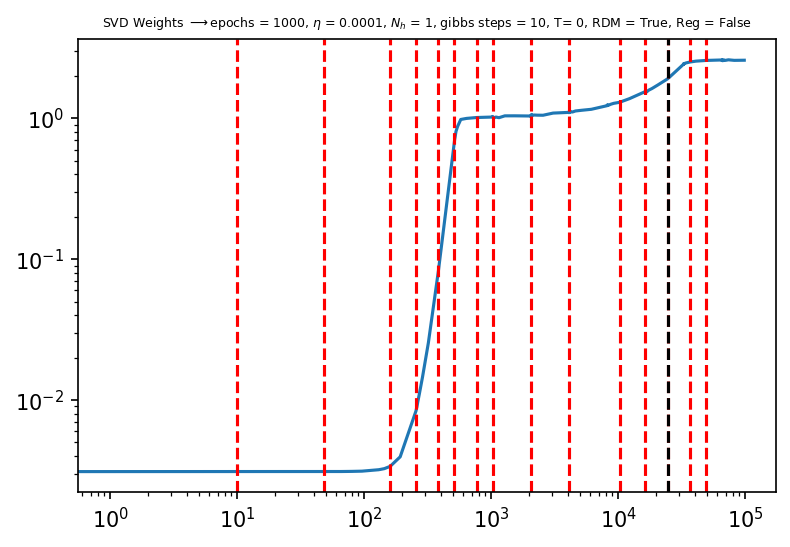

In [6]:
filename = "beta1p5.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

def cambio_tensor(tensor):
    mask = tensor == -1
    tensor[mask] = 0
    return tensor

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())

D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,40):
    for m in range (1,40):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)


n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r') #w - escribir


myRBMG = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

myRBMG.PlotW()

xx = [10,48,160,256,384,512,768,1024,2050,4104,10240,16386,24576,36864,49152] 
for i in xx:
    plt.axvline(x=i, color='r', linestyle='--', label='Línea Vertical')
plt.axvline(x=24576, color='k', linestyle='--', label='Línea Vertical')   

In [14]:
time22 = [10,48,136,160,258,272,384,516,544,768,1028,1056,1280,2050,2064,2176,4096,4112,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152]

### 100 Muestras tamaño 1000

In [9]:
tlist = time22

allt = []
allm = []
allchi = []
filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = Sampling(X,W,b_h,b_v,it)
    
    allt.append(t)
    allm.append(m)
    allchi.append(chi)

KeyboardInterrupt: 

In [144]:
len(allm)

63

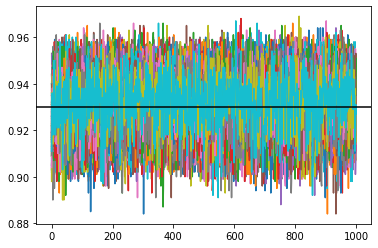

In [132]:
plt.plot(allm[31])
plt.axhline(y=0.93,color = 'k')

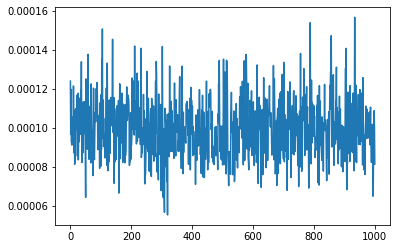

In [133]:
plt.plot(allchi[31])

In [134]:
chilast = []
mlast = []
for i in range (0,37):
    chilast.append(allchi[i][998])
    mlast.append(allm[i][998])

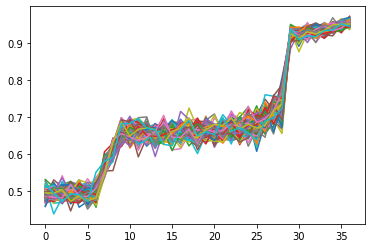

In [135]:
plt.plot(mlast);

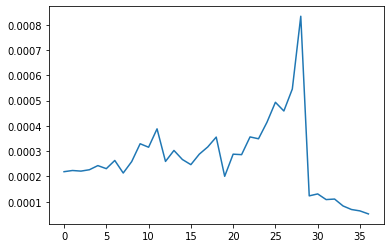

In [136]:
plt.plot(chilast)

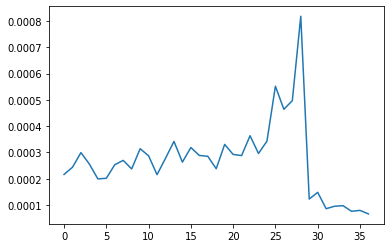

In [62]:
plt.plot(chilast)

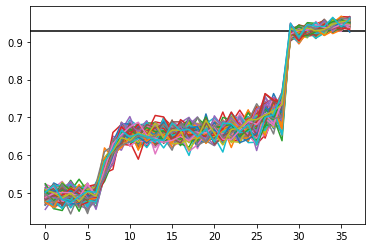

In [28]:
plt.axhline(y=0.93,color = 'k')
plt.plot(np.array(mlast));

### 100 muestras tamaño 1000 a la inversa

In [15]:
tlist0 = [10,48,160,256,384,512,768,1024,2050,4104,10240,16386,24576,36864,49152] 
tlist = sorted(time22, reverse=True)

allt = []
allm = []
allchi = []
filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.ones(1000,100) #todo unos

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = Sampling(X,W,b_h,b_v,it)
    
    allt.append(t)
    allm.append(m)
    allchi.append(chi)

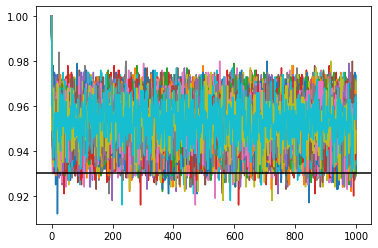

In [50]:
plt.plot(allm[0])
plt.axhline(y=0.93,color = 'k')

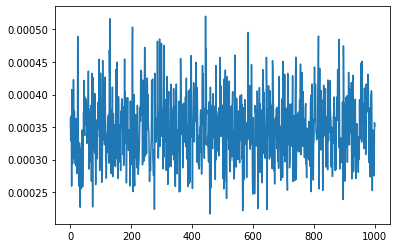

In [51]:
plt.plot(allchi[13])

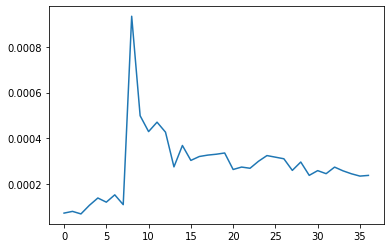

In [52]:
x = np.transpose(allchi)[998]
plt.plot(x)

In [55]:
chilast = []
mlast = []
for i in range (0,37):
    chilast.append(allchi[i][998])
    mlast.append(allm[i][998])

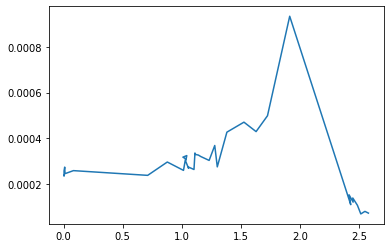

In [56]:
plt.plot(np.array(alls.squeeze(0))[::-1],chilast)

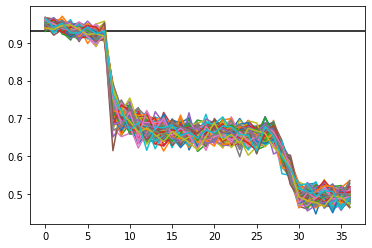

In [57]:
plt.axhline(y=0.93,color = 'k')
plt.plot(np.array(mlast));

### guardemos solo la última de las 1000 iters + overlap

In [16]:
def Vsampling(W,b_v,H):
        mv = torch.sigmoid((W.t().mm(H).t() + b_v).t()) #probabilidad de los nodos visibles
	
        v = torch.bernoulli(mv) #estados de los nodos visibles
        return v,mv

def Hsampling(W,b_h,V):
        
        h_mean = (W.mm(V).t() + b_h).t()
        mh = h_mean #sin sigmoide?
        h = torch.normal(mean=h_mean, std=torch.ones_like(h_mean))

        return h,mh

def Sampling(X,W,b_h,b_v,it): 
        L = X.shape[0]
        N = X.shape[1]
        
        if it==0:
            it = 10

        v = X
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)
        
        for i in range (N):
            for j in range (i+1,N):
                q = torch.mean((2*v[i]-1)*(2*v[j]-1), dim = 0)
                q2 = torch.pow(q,2)
        
        
        h,mh = Hsampling(W,b_h,v)
        v,mv = Vsampling(W,b_v,h)
        
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)
        
        for i in range (N):
            for j in range (i+1,N):
                q = torch.mean((2*v[i]-1)*(2*v[j]-1), dim = 0)
                q2 = torch.pow(q,2)
        
        for t in range(it-1):
            h,mh = Hsampling(W,b_h,v)
            v,mv = Vsampling(W,b_v,h)
            m = torch.mean(v, dim = 0 )
            m2 = torch.pow(m, 2)
            
            for i in range (N):
                for j in range (i+1,N):
                    q = torch.mean((2*v[i]-1)*(2*v[j]-1), dim = 0)
                    q2 = torch.pow(q,2)
        
            
        chi = (1000*(torch.mean(m2)-torch.mean(m)**2).item())
        chi2 = ((torch.mean(q2)-torch.mean(q)**2)/1000).item()
            
            
        return np.array(m),np.array(chi),np.array(chi2),v #estoy guardando todas las m y la última v

In [11]:
tlist = time22

allt = []
allm = []
allchi = []
allchi2 = []
filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,chi2,X = Sampling(X,W,b_h,b_v,it)
    
    allt.append(t)
    allm.append(m)
    allchi.append(chi)
    allchi2.append(chi2)

KeyboardInterrupt: 

In [ ]:
tiempos_uniformes = np.arange(len(allt))

plt.plot(tiempos_uniformes, allm);

step = len(allt) // 10 + 1 
xticks_positions = tiempos_uniformes[::step]
xticks_labels = allt[::step]

# Configurar las etiquetas del eje x
plt.xticks(xticks_positions, xticks_labels)

#plt.plot(allt,allm);
plt.axhline(y=0.93,label = r'$m_o$')
plt.title('Magnetización de samples en distintos t del training')
plt.xlabel('$t_{training}$')
plt.ylabel('m')
plt.legend(loc='lower right')

Text(0, 0.5, '$\\chi$')

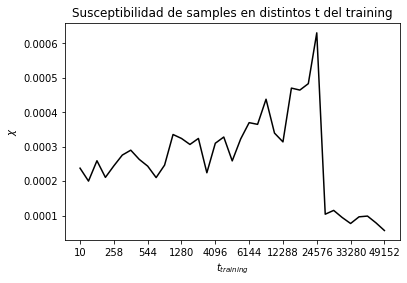

In [39]:
tiempos_uniformes = np.arange(len(allt))

plt.plot(tiempos_uniformes, allchi,'k');

step = len(allt) // 10 + 1 
xticks_positions = tiempos_uniformes[::step]
xticks_labels = allt[::step]

plt.xticks(xticks_positions, xticks_labels)

plt.title('Susceptibilidad de samples en distintos t del training')
plt.xlabel('$t_{training}$')
plt.ylabel('$\chi$')

In [40]:
plt.plot(np.array(alls).squeeze(0),allchi)

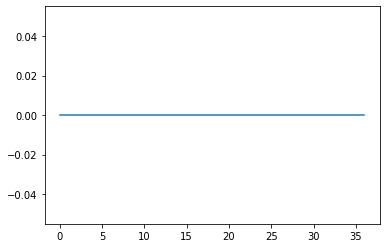

In [41]:
plt.plot(allchi2)

## sin overlap y mayor número de muestras

In [17]:
def Vsampling(W,b_v,H):
        mv = torch.sigmoid((W.t().mm(H).t() + b_v).t()) #probabilidad de los nodos visibles
	
        v = torch.bernoulli(mv) #estados de los nodos visibles
        return v,mv

def Hsampling(W,b_h,V):
        
        h_mean = (W.mm(V).t() + b_h).t()
        mh = h_mean #sin sigmoide?
        h = torch.normal(mean=h_mean, std=torch.ones_like(h_mean))

        return h,mh

def Sampling2(X,W,b_h,b_v,it): 
        L = X.shape[0]
        N = X.shape[1]
        
        if it==0:
            it = 10

        v = X
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)
        

        h,mh = Hsampling(W,b_h,v)
        v,mv = Vsampling(W,b_v,h)
        
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)

        for t in range(it-1):
            h,mh = Hsampling(W,b_h,v)
            v,mv = Vsampling(W,b_v,h)
            m = torch.mean(v, dim = 0 )
            m2 = torch.pow(m, 2)

            
        chi = (1000*(torch.mean(m2)-torch.mean(m)**2)).item()
            
            
        return np.array(m),np.array(chi),v #estoy guardando todas las m y la última v

In [46]:
tlist = time22

allt2= []
allm2 = []
allchi22 = []
filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,2000),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = Sampling2(X,W,b_h,b_v,it)
    
    allt2.append(t)
    allm2.append(m)
    allchi22.append(chi)

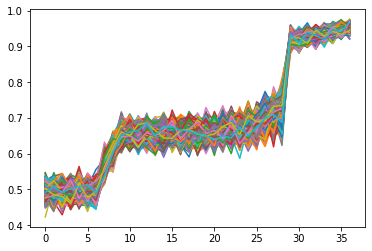

In [48]:
plt.plot(allm2);

Text(0, 0.5, '$\\chi$')

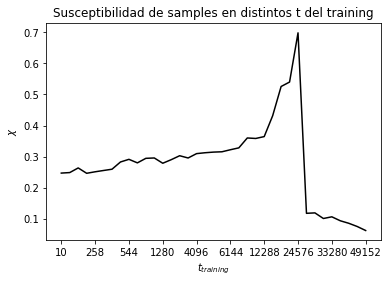

In [52]:
tiempos_uniformes = np.arange(len(allt))

plt.plot(tiempos_uniformes, allchi22,'k');

step = len(allt) // 10 + 1 
xticks_positions = tiempos_uniformes[::step]
xticks_labels = allt[::step]

plt.xticks(xticks_positions, xticks_labels)

plt.title('Susceptibilidad de samples en distintos t del training')
plt.xlabel('$t_{training}$')
plt.ylabel('$\chi$')

In [50]:
np.shape(allm2)

(37, 2000)

### L pequeñas

In [18]:
filename =  'files/RDMG_CWM_1p5L100_n1_b100_l1e4_k10_ek.h5'
tlist =  [10,160,258,384,516,1056,1280,2064,2176,4096,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152,65536,65540,65552,65664]
allt3 = []
allm3 = []
allchi3 = []
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((100,1000),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = Sampling2(X,W,b_h,b_v,it)
    
    allt3.append(t)
    allm3.append(m)
    allchi3.append(chi)

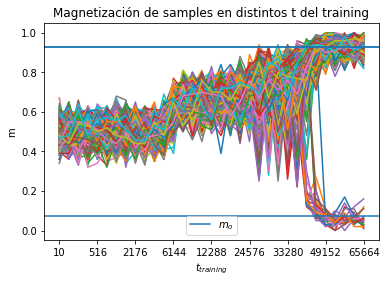

In [21]:
tiempos_uniformes = np.arange(len(allt3))

plt.plot(tiempos_uniformes, allm3);

step = len(allt3) // 10 + 1 
xticks_positions = tiempos_uniformes[::step]
xticks_labels = allt3[::step]

# Configurar las etiquetas del eje x
plt.xticks(xticks_positions, xticks_labels)

#plt.plot(allt,allm);
plt.axhline(y=0.93,label = r'$m_o$')
plt.title('Magnetización de samples en distintos t del training')
plt.xlabel('$t_{training}$')
plt.ylabel('m')
plt.legend(loc='lower center')
plt.axhline(y=0.93,label = r'$m_o$')
plt.axhline(y=0.071,label = r'$m_o$')

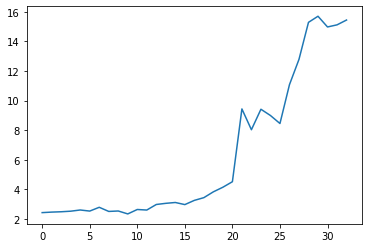

In [25]:
plt.plot(allchi3)

In [25]:
(-0.858+1)/2

0.07100000000000001

# 2. Comparación dinámica analítica.

/tmp/ipykernel_4004/658384470.py:44: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,700)
/tmp/ipykernel_4004/658384470.py:45: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-3e-3,1.2)


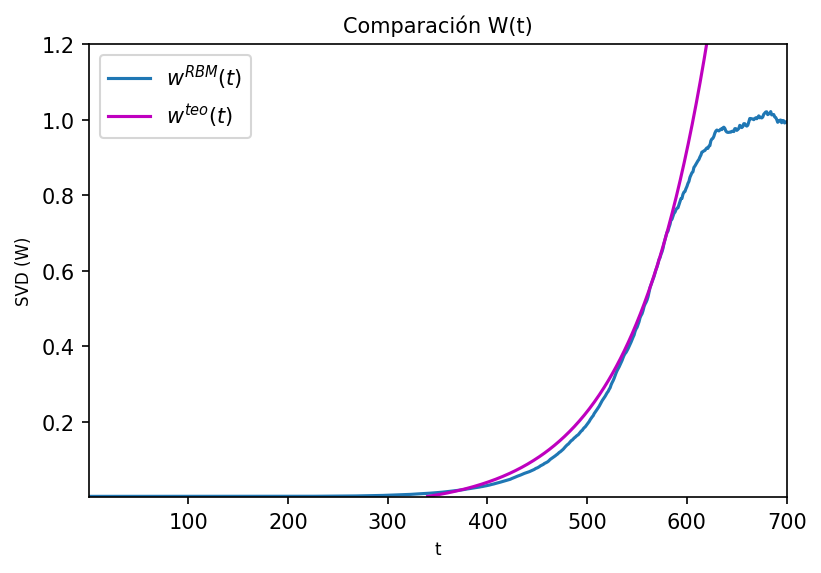

In [9]:
n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_CWM_1p5_muchost.h5'
f = h5py.File(filename,'r') #w - escribir


myRBMG = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

myRBMG.PlotW()

fig = plt.gcf()
ax = plt.gca()

# Obtener la última línea dibujada y agregarle una etiqueta
line = ax.get_lines()[-1]
line.set_label( r'$w^{RBM}(t)$')

m0 = 0.885
m = (m0+1)/2

w = []
lr = 1e-4
N = 188

allt = np.linspace(0, 10**3, 1000)
        
for tt in allt:
    
    w.append(3e-3+(1/np.sqrt(1000))*(np.exp((m**2-m+3/4)*tt*lr*N)-1))

plt.title('Comparación W(t)', fontsize = 10)
plt.plot(allt+340,w,label = r'$w^{teo}(t)$',color = 'm')
plt.xlim(0,700)
plt.ylim(-3e-3,1.2)
plt.xlabel('t', fontsize = 8)
plt.ylabel('SVD (W)', fontsize = 8)
plt.gca().set_yscale('linear')
plt.gca().set_xscale('linear')
plt.legend()
plt.show()

/tmp/ipykernel_3676/397746205.py:38: UserWarning: Attempt to set non-positive xlim on a log-scaled axis will be ignored.
  plt.xlim(0,700)
/tmp/ipykernel_3676/397746205.py:39: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(-3e-3,1.5)


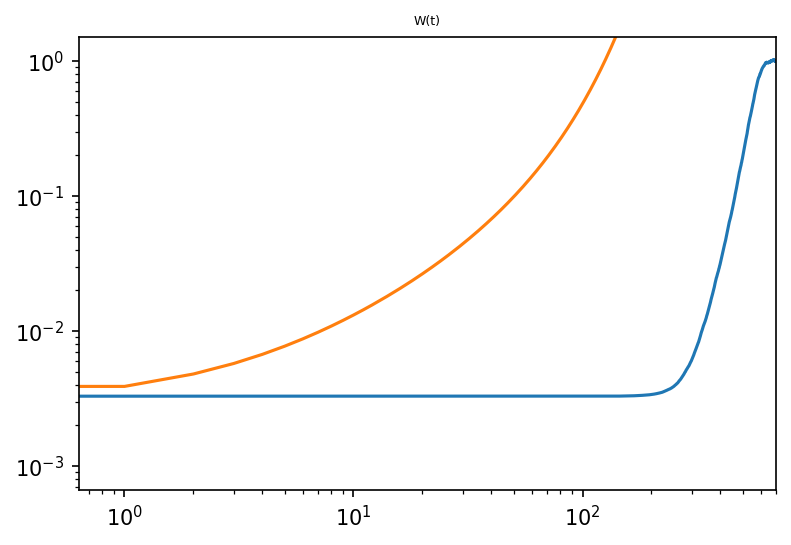

In [41]:
n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_CWM_1p5_muchost.h5'
f = h5py.File(filename,'r') #w - escribir


myRBMG = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

myRBMG.PlotW()


m0 = 0.885
m = (m0+1)/2

w = []
lr = 1e-4
N = 400

allt = np.linspace(0, 10**3, 1000)
        
for tt in allt:
    
    w.append(3e-3+(1/np.sqrt(1000))*(np.exp((m**2-m+3/4)*tt*lr*N)-1))

plt.title('W(t)', fontsize = 6)
plt.loglog(allt,w)
plt.xlim(0,700)
plt.ylim(-3e-3,1.5)
#plt.gca().set_yscale('linear')
#plt.gca().set_xscale('linear')
plt.show()

/tmp/ipykernel_5222/3002588585.py:41: UserWarning: Attempt to set non-positive ylim on a log-scaled axis will be ignored.
  plt.ylim(0,3)


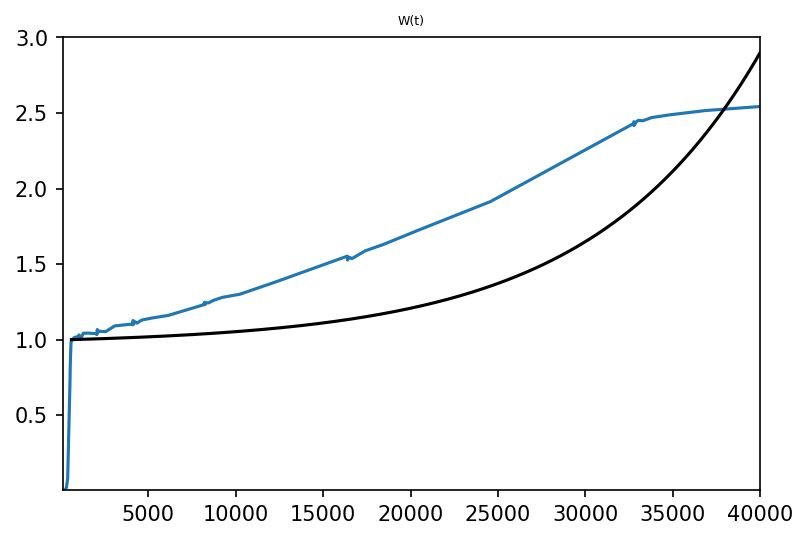

In [20]:
n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r') #w - escribir


myRBMG = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

myRBMG.PlotW()


m0 = 0.885
m = (m0+1)/2

w = []
w1 = []
w2 = []
lr = 1e-4

N = 1.5
#allt = np.linspace(7*10**2, 5*10**4, 1000)

allt = np.linspace(0, 10**5, 1000)
for tt in allt:
    
    w.append(1+(1/np.sqrt(1000))*(np.exp(((m**2)-m+3/4)*tt*lr*N)-1))

plt.title('W(t)', fontsize = 6)
plt.xlim(10**2,4*10**4)
plt.ylim(0,3)
plt.plot(allt+6*10**2,w,'k')
plt.gca().set_yscale('linear')
plt.gca().set_xscale('linear')
plt.show()

## 3. Punto fijo para encontrar la solución de w

In [86]:
def sigmoid(x): 
    return 1/(1+np.exp(-x))

1) $\sigma(hw)w-h=0$

2) $m^2-m+1/2=\sigma^2(hw)$

In [146]:
m0 = 0.8585634818505868
m = (m0+1)/2

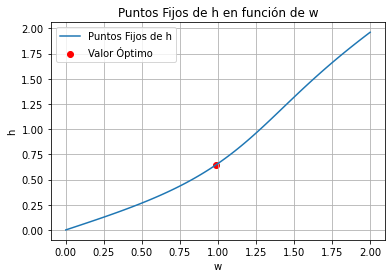

Valor óptimo de h: 0.6485972739364548
Valor óptimo de w: 0.98989898989899


In [147]:
import numpy as np
import matplotlib.pyplot as plt

def sigmoid(x):
    return 1 / (1 + np.exp(-x))

def fixed_point_iteration(w_values, initial_h, max_iterations=100, tolerance=1e-6):
    h_values = []
    for w in w_values:
        h = initial_h
        for _ in range(max_iterations):
            h_next = sigmoid(h * w) * w
            if abs(h_next - h) < tolerance:
                h = h_next
                break
            h = h_next
        h_values.append(h)
    return h_values

def optimal_values(w_values, h_values):

    optimal_h = None
    optimal_w = None
    min_difference = float('inf')
    for i, h in enumerate(h_values):
        w = w_values[i]
        sigmoid_hw = sigmoid(h * w)
        difference = abs(m**2 - m + 0.5 - sigmoid_hw**2)
        if difference < min_difference:
            min_difference = difference
            optimal_h = h
            optimal_w = w
    return optimal_h, optimal_w

# Definir rango de valores de w
w_values = np.linspace(0, 2, 100)

# Calcular puntos fijos de h
initial_h = 0.5
h_values = fixed_point_iteration(w_values, initial_h)

# Encontrar valores óptimos de h y w
optimal_h, optimal_w = optimal_values(w_values, h_values)

# Graficar los puntos fijos de h en función de w
plt.plot(w_values, h_values, label='Puntos Fijos de h')
plt.scatter(optimal_w, optimal_h, color='red', label='Valor Óptimo')
plt.xlabel('w')
plt.ylabel('h')
plt.title('Puntos Fijos de h en función de w')
plt.legend()
plt.grid(True)
plt.show()

print("Valor óptimo de h:", optimal_h)
print("Valor óptimo de w:", optimal_w)


# 4. Training beta = 2

In [4]:
def cambio_energia(SM,J,h,N,i):
	#Energía promedio
	E = ((2*J/N)*sum(np.delete(SM,i))+2*h)*SM[i]
	return E

def HB(N,J,h,it,beta):
	m = []
	chi = []
	mat = []
	SM = np.random.choice([-1,1],[N])
	
	for j in range (it):
		for k in range(N):
			i = np.random.randint(N)
			ΔE = cambio_energia(SM,J,h,N,i)
			p = 1/(1+np.exp(beta*ΔE))
			if np.random.random() < p:
					SM[i] *= -1

		m.append(np.mean(SM))
		chi.append(beta*(np.mean(SM**2) - np.mean(SM)**2))
		mat.append(SM)
		
	return m,chi,SM

In [3]:
L = 1000
J = 1
h = 0
beta = 2
it = 80

# c - matriz axb
# Data - Tensor (axb,iter)

nro = 5000
Data = np.zeros([L,nro])

for i in range(nro):
    a,b,c = HB(L,J,h,it,beta)
    Data[:,i] = c
    
filename = "beta2.h5py"

with h5py.File(filename, "w") as f:
    dset = f.create_dataset("Data", data=Data)

NameError: name 'HB' is not defined

In [4]:
def cambio_tensor(tensor):
    mask = tensor == -1
    tensor[mask] = 0
    return tensor
filename = "beta2.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())  


In [4]:
d.shape

torch.Size([1000, 5000])

In [5]:

D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,40):
    for m in range (1,40):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)


n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDMG_CWM_2_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r') #w - escribir


myRBMG = rbmg.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_4004/1147267839.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


In [11]:
myRBMG.SetVisBias(D)
myRBMG.train(D)

It =  0 loss tensor(25.0096)
It =  1 loss tensor(12.4989)
It =  2 loss tensor(8.3301)
It =  3 loss tensor(6.2525)
It =  4 loss tensor(5.0017)
It =  5 loss tensor(4.1676)
It =  6 loss tensor(3.5717)
It =  7 loss tensor(3.1363)
It =  8 loss tensor(2.7879)
It =  9 loss tensor(2.5098)
It =  10 loss tensor(2.2809)
It =  11 loss tensor(2.0909)
It =  12 loss tensor(1.9296)
It =  13 loss tensor(1.7940)
It =  14 loss tensor(1.6740)
It =  15 loss tensor(1.5677)
It =  16 loss tensor(1.4763)
It =  17 loss tensor(1.3939)
It =  18 loss tensor(1.3204)
It =  19 loss tensor(1.2559)
It =  20 loss tensor(1.1944)
It =  21 loss tensor(1.1404)
It =  22 loss tensor(1.0911)
It =  23 loss tensor(1.0456)
It =  24 loss tensor(1.0043)
It =  25 loss tensor(0.9654)
It =  26 loss tensor(0.9294)
It =  27 loss tensor(0.8964)
It =  28 loss tensor(0.8654)
It =  29 loss tensor(0.8366)
It =  30 loss tensor(0.8105)
It =  31 loss tensor(0.7838)
It =  32 loss tensor(0.7606)
It =  33 loss tensor(0.7390)
It =  34 loss tensor(0

It =  277 loss tensor(0.0903)
It =  278 loss tensor(0.0901)
It =  279 loss tensor(0.0898)
It =  280 loss tensor(0.0894)
It =  281 loss tensor(0.0891)
It =  282 loss tensor(0.0887)
It =  283 loss tensor(0.0885)
It =  284 loss tensor(0.0881)
It =  285 loss tensor(0.0878)
It =  286 loss tensor(0.0875)
It =  287 loss tensor(0.0872)
It =  288 loss tensor(0.0869)
It =  289 loss tensor(0.0866)
It =  290 loss tensor(0.0863)
It =  291 loss tensor(0.0860)
It =  292 loss tensor(0.0857)
It =  293 loss tensor(0.0854)
It =  294 loss tensor(0.0852)
It =  295 loss tensor(0.0848)
It =  296 loss tensor(0.0846)
It =  297 loss tensor(0.0842)
It =  298 loss tensor(0.0840)
It =  299 loss tensor(0.0837)
It =  300 loss tensor(0.0835)
It =  301 loss tensor(0.0831)
It =  302 loss tensor(0.0829)
It =  303 loss tensor(0.0826)
It =  304 loss tensor(0.0824)
It =  305 loss tensor(0.0821)
It =  306 loss tensor(0.0818)
It =  307 loss tensor(0.0815)
It =  308 loss tensor(0.0813)
It =  309 loss tensor(0.0810)
It =  310 

It =  551 loss tensor(0.0452)
It =  552 loss tensor(0.0445)
It =  553 loss tensor(0.0447)
It =  554 loss tensor(0.0446)
It =  555 loss tensor(0.0456)
It =  556 loss tensor(0.0447)
It =  557 loss tensor(0.0448)
It =  558 loss tensor(0.0448)
It =  559 loss tensor(0.0446)
It =  560 loss tensor(0.0455)
It =  561 loss tensor(0.0443)
It =  562 loss tensor(0.0437)
It =  563 loss tensor(0.0437)
It =  564 loss tensor(0.0451)
It =  565 loss tensor(0.0451)
It =  566 loss tensor(0.0451)
It =  567 loss tensor(0.0446)
It =  568 loss tensor(0.0442)
It =  569 loss tensor(0.0447)
It =  570 loss tensor(0.0442)
It =  571 loss tensor(0.0439)
It =  572 loss tensor(0.0431)
It =  573 loss tensor(0.0443)
It =  574 loss tensor(0.0437)
It =  575 loss tensor(0.0436)
It =  576 loss tensor(0.0428)
It =  577 loss tensor(0.0439)
It =  578 loss tensor(0.0431)
It =  579 loss tensor(0.0429)
It =  580 loss tensor(0.0433)
It =  581 loss tensor(0.0427)
It =  582 loss tensor(0.0434)
It =  583 loss tensor(0.0436)
It =  584 

It =  825 loss tensor(0.0298)
It =  826 loss tensor(0.0300)
It =  827 loss tensor(0.0300)
It =  828 loss tensor(0.0300)
It =  829 loss tensor(0.0296)
It =  830 loss tensor(0.0301)
It =  831 loss tensor(0.0297)
It =  832 loss tensor(0.0304)
It =  833 loss tensor(0.0301)
It =  834 loss tensor(0.0301)
It =  835 loss tensor(0.0296)
It =  836 loss tensor(0.0298)
It =  837 loss tensor(0.0299)
It =  838 loss tensor(0.0302)
It =  839 loss tensor(0.0295)
It =  840 loss tensor(0.0299)
It =  841 loss tensor(0.0299)
It =  842 loss tensor(0.0301)
It =  843 loss tensor(0.0291)
It =  844 loss tensor(0.0295)
It =  845 loss tensor(0.0300)
It =  846 loss tensor(0.0295)
It =  847 loss tensor(0.0294)
It =  848 loss tensor(0.0296)
It =  849 loss tensor(0.0292)
It =  850 loss tensor(0.0297)
It =  851 loss tensor(0.0295)
It =  852 loss tensor(0.0295)
It =  853 loss tensor(0.0290)
It =  854 loss tensor(0.0294)
It =  855 loss tensor(0.0280)
It =  856 loss tensor(0.0288)
It =  857 loss tensor(0.0297)
It =  858 

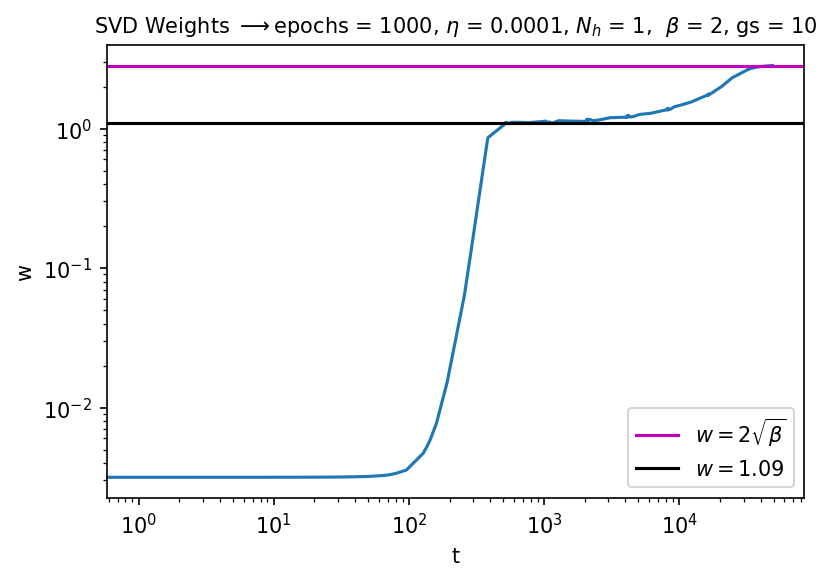

In [8]:
myRBMG.PlotW()
plt.axhline(y=2*np.sqrt(2), color='m', linestyle='-', label=r'$w = 2\sqrt{\beta}$')
plt.axhline(y=1.09, color='k', linestyle='-', label='$w = 1.09 $')
plt.title(r'SVD Weights $\longrightarrow$epochs = 1000, $\eta$ = 0.0001, $N_h$ = 1,  $\beta$ = 2, gs = 10', fontsize = 10)
plt.xlabel('t')
plt.ylabel('w')
plt.legend()
plt.show()

# Tamaño más grande de L

# Curie - Weiss RBM

### 1.5 - 1e-2

In [13]:
def Vsampling(W,b_v,H):
        mv = torch.sigmoid((W.t().mm(H).t() + b_v).t()) #probabilidad de los nodos visibles
	
        v = torch.bernoulli(mv) #estados de los nodos visibles
        return v,mv

def HsamplingB(W,b_h,V):
        
        mh = torch.sigmoid((W.mm(V).t()+b_h).t())
        h = torch.bernoulli(mh)
        return h,mh

def SamplingB(X,W,b_h,b_v,it): 
        L = X.shape[0]
        N = X.shape[1]
        
        if it==0:
            it = 10

        v = X
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)
        

        h,mh = HsamplingB(W,b_h,v)
        v,mv = Vsampling(W,b_v,h)
        
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)

        for t in range(it-1):
            h,mh = HsamplingB(W,b_h,v)
            v,mv = Vsampling(W,b_v,h)
            m = torch.mean(v, dim = 0 )
            m2 = torch.pow(m, 2)

            
        chi = (1000*(torch.mean(m2)-torch.mean(m)**2)).item()
            
            
        return np.array(m),np.array(chi),v #estoy guardando todas las m y la última v

In [15]:
def cambio_tensor(tensor):
    mask = tensor == -1
    tensor[mask] = 0
    return tensor

filename = "beta1p5.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())
                  
D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,30):
    for m in range (1,30):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-2
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDM_CWM_1.5_n1_b100_l1e3_k10_ek.h5'
f = h5py.File(filename,'r') #w - escribir
#f.create_dataset('alltime',data=time)
#f.close()

myRBMG3 = rbm.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_3886/2870776795.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


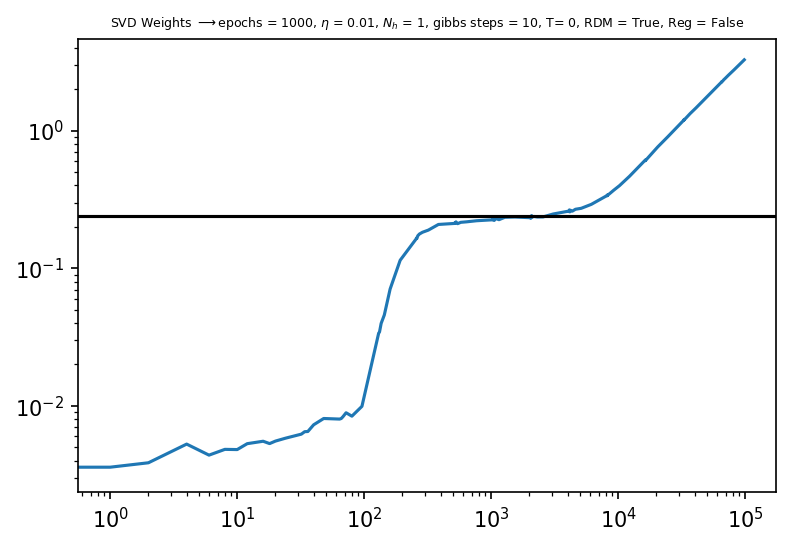

In [82]:
myRBMG3.PlotW()
plt.axhline(y=0.24,color = 'k')

### 1.5 - 1e-4

In [16]:
D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,30):
    for m in range (1,30):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDM_CWM_1.5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r') #w - escribir
#f.create_dataset('alltime',data=time)
#f.close()

myRBM = rbm.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_3886/3156842209.py:1: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


In [10]:
myRBM.SetVisBias(D)
myRBM.train(D)

It =  0 loss tensor(49.9903)
It =  1 loss tensor(24.9975)
It =  2 loss tensor(16.6644)
It =  3 loss tensor(12.4968)
It =  4 loss tensor(10.0010)
It =  5 loss tensor(8.3301)
It =  6 loss tensor(7.1441)
It =  7 loss tensor(6.2499)
It =  8 loss tensor(5.5514)
It =  9 loss tensor(4.9986)
It =  10 loss tensor(4.5467)
It =  11 loss tensor(4.1679)
It =  12 loss tensor(3.8455)
It =  13 loss tensor(3.5747)
It =  14 loss tensor(3.3369)
It =  15 loss tensor(3.1265)
It =  16 loss tensor(2.9411)
It =  17 loss tensor(2.7774)
It =  18 loss tensor(2.6321)
It =  19 loss tensor(2.5004)
It =  20 loss tensor(2.3803)
It =  21 loss tensor(2.2723)
It =  22 loss tensor(2.1744)
It =  23 loss tensor(2.0812)
It =  24 loss tensor(2.0000)
It =  25 loss tensor(1.9231)
It =  26 loss tensor(1.8513)
It =  27 loss tensor(1.7849)
It =  28 loss tensor(1.7238)
It =  29 loss tensor(1.6665)
It =  30 loss tensor(1.6120)
It =  31 loss tensor(1.5619)
It =  32 loss tensor(1.5144)
It =  33 loss tensor(1.4700)
It =  34 loss tenso

It =  277 loss tensor(0.1798)
It =  278 loss tensor(0.1792)
It =  279 loss tensor(0.1785)
It =  280 loss tensor(0.1779)
It =  281 loss tensor(0.1772)
It =  282 loss tensor(0.1766)
It =  283 loss tensor(0.1760)
It =  284 loss tensor(0.1754)
It =  285 loss tensor(0.1748)
It =  286 loss tensor(0.1742)
It =  287 loss tensor(0.1736)
It =  288 loss tensor(0.1730)
It =  289 loss tensor(0.1724)
It =  290 loss tensor(0.1718)
It =  291 loss tensor(0.1712)
It =  292 loss tensor(0.1706)
It =  293 loss tensor(0.1701)
It =  294 loss tensor(0.1695)
It =  295 loss tensor(0.1689)
It =  296 loss tensor(0.1683)
It =  297 loss tensor(0.1678)
It =  298 loss tensor(0.1672)
It =  299 loss tensor(0.1667)
It =  300 loss tensor(0.1661)
It =  301 loss tensor(0.1655)
It =  302 loss tensor(0.1649)
It =  303 loss tensor(0.1645)
It =  304 loss tensor(0.1639)
It =  305 loss tensor(0.1633)
It =  306 loss tensor(0.1629)
It =  307 loss tensor(0.1624)
It =  308 loss tensor(0.1617)
It =  309 loss tensor(0.1612)
It =  310 

It =  551 loss tensor(0.0906)
It =  552 loss tensor(0.0904)
It =  553 loss tensor(0.0903)
It =  554 loss tensor(0.0901)
It =  555 loss tensor(0.0899)
It =  556 loss tensor(0.0898)
It =  557 loss tensor(0.0896)
It =  558 loss tensor(0.0894)
It =  559 loss tensor(0.0893)
It =  560 loss tensor(0.0891)
It =  561 loss tensor(0.0889)
It =  562 loss tensor(0.0887)
It =  563 loss tensor(0.0886)
It =  564 loss tensor(0.0885)
It =  565 loss tensor(0.0883)
It =  566 loss tensor(0.0881)
It =  567 loss tensor(0.0880)
It =  568 loss tensor(0.0879)
It =  569 loss tensor(0.0877)
It =  570 loss tensor(0.0875)
It =  571 loss tensor(0.0873)
It =  572 loss tensor(0.0873)
It =  573 loss tensor(0.0871)
It =  574 loss tensor(0.0870)
It =  575 loss tensor(0.0868)
It =  576 loss tensor(0.0867)
It =  577 loss tensor(0.0865)
It =  578 loss tensor(0.0864)
It =  579 loss tensor(0.0862)
It =  580 loss tensor(0.0861)
It =  581 loss tensor(0.0859)
It =  582 loss tensor(0.0858)
It =  583 loss tensor(0.0856)
It =  584 

It =  825 loss tensor(0.0605)
It =  826 loss tensor(0.0605)
It =  827 loss tensor(0.0604)
It =  828 loss tensor(0.0603)
It =  829 loss tensor(0.0603)
It =  830 loss tensor(0.0602)
It =  831 loss tensor(0.0601)
It =  832 loss tensor(0.0601)
It =  833 loss tensor(0.0599)
It =  834 loss tensor(0.0599)
It =  835 loss tensor(0.0598)
It =  836 loss tensor(0.0597)
It =  837 loss tensor(0.0596)
It =  838 loss tensor(0.0596)
It =  839 loss tensor(0.0595)
It =  840 loss tensor(0.0594)
It =  841 loss tensor(0.0594)
It =  842 loss tensor(0.0593)
It =  843 loss tensor(0.0592)
It =  844 loss tensor(0.0592)
It =  845 loss tensor(0.0591)
It =  846 loss tensor(0.0590)
It =  847 loss tensor(0.0590)
It =  848 loss tensor(0.0589)
It =  849 loss tensor(0.0588)
It =  850 loss tensor(0.0588)
It =  851 loss tensor(0.0587)
It =  852 loss tensor(0.0586)
It =  853 loss tensor(0.0585)
It =  854 loss tensor(0.0585)
It =  855 loss tensor(0.0584)
It =  856 loss tensor(0.0584)
It =  857 loss tensor(0.0583)
It =  858 

In [21]:
alltime = np.sort(f['alltime'])
alltime

array([         0,          1,          2,          4,          6,
                8,         10,         12,         16,         18,
               20,         24,         32,         34,         36,
               40,         48,         64,         66,         68,
               72,         80,         96,        128,        130,
              132,        136,        144,        160,        192,
              256,        258,        260,        264,        272,
              288,        320,        384,        512,        514,
              516,        520,        528,        544,        576,
              640,        768,       1024,       1026,       1028,
             1032,       1040,       1056,       1088,       1152,
             1280,       1536,       2048,       2050,       2052,
             2056,       2064,       2080,       2112,       2176,
             2304,       2560,       3072,       4096,       4098,
             4100,       4104,       4112,       4128,       4

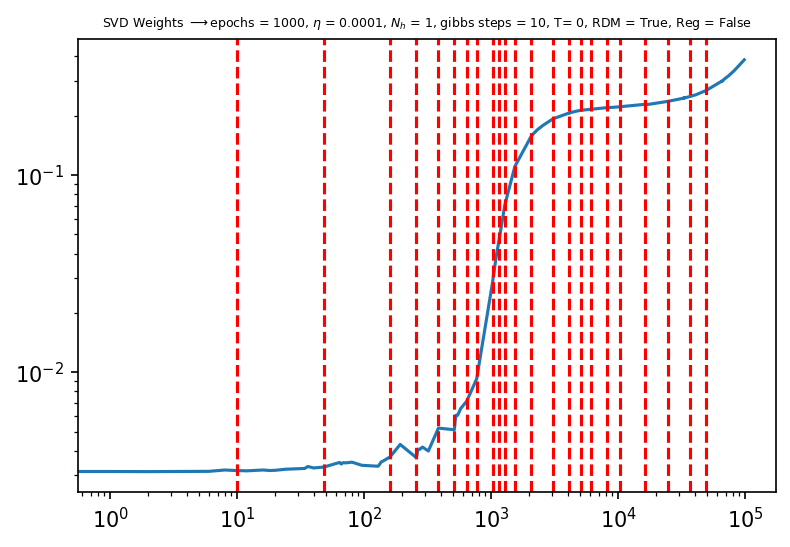

In [26]:
myRBM.PlotW()

xx = [10,48,160,256,384,512,640,768,1024,1152,1280,1536,2050,3072,4104,5120,6144,8192,10240,16386,24576,36864,49152] 
for i in xx:
    plt.axvline(x=i, color='r', linestyle='--', label='Línea Vertical') 

In [27]:
filename = 'files/RDM_CWM_1.5_n1_b100_l1e3_k10_ek.h5'

tlist =  [10,48,160,256,384,512,640,768,1024,1152,1280,1536,2050,3072,4104,5120,6144,8192,10240,16386,24576,36864,49152] 

allt3 = []
allm3 = []
allchi3 = []
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = SamplingB(X,W,b_h,b_v,it)
    
    allt3.append(t)
    allm3.append(m)
    allchi3.append(chi)

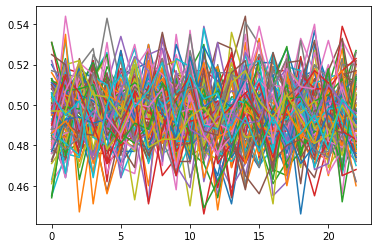

In [28]:
plt.plot(allm3);

### 2 - 1e-2

In [91]:
def cambio_tensor(tensor):
    mask = tensor == -1
    tensor[mask] = 0
    return tensor

filename = "beta2.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())
                  
D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,30):
    for m in range (1,30):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-2
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDM_CWM_2_n1_b100_l1e3_k10_ek.h5'
f = h5py.File(filename,'w') #w - escribir
f.create_dataset('alltime',data=time)
f.close()

myRBM4 = rbm.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_5467/1277658145.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


In [92]:
myRBM4.SetVisBias(D)
myRBM4.train(D)

It =  0 loss tensor(24.9802)
It =  1 loss tensor(12.4929)
It =  2 loss tensor(8.3353)
It =  3 loss tensor(6.2480)
It =  4 loss tensor(5.0031)
It =  5 loss tensor(4.1685)
It =  6 loss tensor(3.5711)
It =  7 loss tensor(3.1243)
It =  8 loss tensor(2.7754)
It =  9 loss tensor(2.4999)
It =  10 loss tensor(2.2708)
It =  11 loss tensor(2.0829)
It =  12 loss tensor(1.9224)
It =  13 loss tensor(1.7855)
It =  14 loss tensor(1.6665)
It =  15 loss tensor(1.5627)
It =  16 loss tensor(1.4708)
It =  17 loss tensor(1.3884)
It =  18 loss tensor(1.3157)
It =  19 loss tensor(1.2500)
It =  20 loss tensor(1.1904)
It =  21 loss tensor(1.1351)
It =  22 loss tensor(1.0871)
It =  23 loss tensor(1.0416)
It =  24 loss tensor(1.0002)
It =  25 loss tensor(0.9609)
It =  26 loss tensor(0.9259)
It =  27 loss tensor(0.8928)
It =  28 loss tensor(0.8619)
It =  29 loss tensor(0.8337)
It =  30 loss tensor(0.8067)
It =  31 loss tensor(0.7811)
It =  32 loss tensor(0.7576)
It =  33 loss tensor(0.7357)
It =  34 loss tensor(0

It =  277 loss tensor(0.0899)
It =  278 loss tensor(0.0896)
It =  279 loss tensor(0.0894)
It =  280 loss tensor(0.0890)
It =  281 loss tensor(0.0886)
It =  282 loss tensor(0.0883)
It =  283 loss tensor(0.0881)
It =  284 loss tensor(0.0877)
It =  285 loss tensor(0.0874)
It =  286 loss tensor(0.0871)
It =  287 loss tensor(0.0868)
It =  288 loss tensor(0.0865)
It =  289 loss tensor(0.0862)
It =  290 loss tensor(0.0859)
It =  291 loss tensor(0.0856)
It =  292 loss tensor(0.0853)
It =  293 loss tensor(0.0850)
It =  294 loss tensor(0.0847)
It =  295 loss tensor(0.0844)
It =  296 loss tensor(0.0842)
It =  297 loss tensor(0.0838)
It =  298 loss tensor(0.0836)
It =  299 loss tensor(0.0833)
It =  300 loss tensor(0.0832)
It =  301 loss tensor(0.0828)
It =  302 loss tensor(0.0824)
It =  303 loss tensor(0.0822)
It =  304 loss tensor(0.0820)
It =  305 loss tensor(0.0817)
It =  306 loss tensor(0.0814)
It =  307 loss tensor(0.0812)
It =  308 loss tensor(0.0809)
It =  309 loss tensor(0.0807)
It =  310 

It =  551 loss tensor(0.0453)
It =  552 loss tensor(0.0453)
It =  553 loss tensor(0.0452)
It =  554 loss tensor(0.0451)
It =  555 loss tensor(0.0449)
It =  556 loss tensor(0.0449)
It =  557 loss tensor(0.0448)
It =  558 loss tensor(0.0447)
It =  559 loss tensor(0.0446)
It =  560 loss tensor(0.0445)
It =  561 loss tensor(0.0445)
It =  562 loss tensor(0.0445)
It =  563 loss tensor(0.0443)
It =  564 loss tensor(0.0442)
It =  565 loss tensor(0.0441)
It =  566 loss tensor(0.0441)
It =  567 loss tensor(0.0440)
It =  568 loss tensor(0.0439)
It =  569 loss tensor(0.0438)
It =  570 loss tensor(0.0438)
It =  571 loss tensor(0.0437)
It =  572 loss tensor(0.0436)
It =  573 loss tensor(0.0435)
It =  574 loss tensor(0.0435)
It =  575 loss tensor(0.0434)
It =  576 loss tensor(0.0433)
It =  577 loss tensor(0.0433)
It =  578 loss tensor(0.0432)
It =  579 loss tensor(0.0431)
It =  580 loss tensor(0.0430)
It =  581 loss tensor(0.0429)
It =  582 loss tensor(0.0429)
It =  583 loss tensor(0.0428)
It =  584 

It =  825 loss tensor(0.0303)
It =  826 loss tensor(0.0303)
It =  827 loss tensor(0.0302)
It =  828 loss tensor(0.0302)
It =  829 loss tensor(0.0301)
It =  830 loss tensor(0.0301)
It =  831 loss tensor(0.0301)
It =  832 loss tensor(0.0300)
It =  833 loss tensor(0.0300)
It =  834 loss tensor(0.0299)
It =  835 loss tensor(0.0299)
It =  836 loss tensor(0.0299)
It =  837 loss tensor(0.0298)
It =  838 loss tensor(0.0298)
It =  839 loss tensor(0.0298)
It =  840 loss tensor(0.0297)
It =  841 loss tensor(0.0297)
It =  842 loss tensor(0.0296)
It =  843 loss tensor(0.0296)
It =  844 loss tensor(0.0296)
It =  845 loss tensor(0.0296)
It =  846 loss tensor(0.0295)
It =  847 loss tensor(0.0295)
It =  848 loss tensor(0.0295)
It =  849 loss tensor(0.0294)
It =  850 loss tensor(0.0294)
It =  851 loss tensor(0.0293)
It =  852 loss tensor(0.0293)
It =  853 loss tensor(0.0292)
It =  854 loss tensor(0.0292)
It =  855 loss tensor(0.0292)
It =  856 loss tensor(0.0292)
It =  857 loss tensor(0.0292)
It =  858 

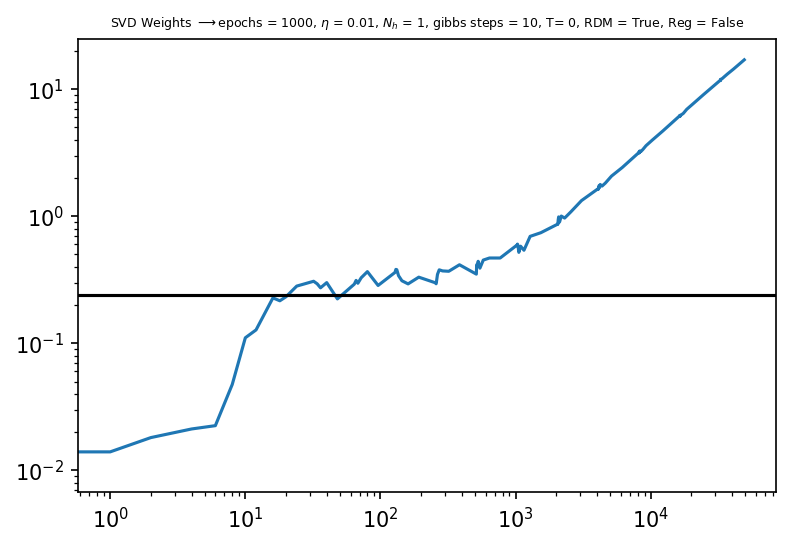

In [97]:
myRBM4.PlotW()

plt.axhline(y=0.24,color = 'k')

In [14]:
filename = 'files/RDM_CWM_2_n1_b100_l1e3_k10_ek.h5'

tlist =  [10,160,258,384,516,1056,1280,2064,2176,4096,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152,65536,65540,65552,65664]
allt3 = []
allm3 = []
allchi3 = []
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = SamplingB(X,W,b_h,b_v,it)
    
    allt3.append(t)
    allm3.append(m)
    allchi3.append(chi)

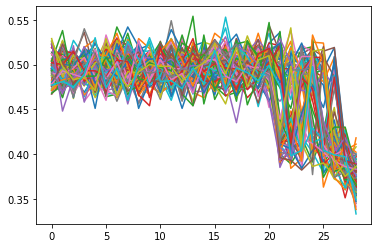

In [15]:
plt.plot(allm3);

### 2 - 1E-4

In [ ]:
def cambio_tensor(tensor):
    mask = tensor == -1
    tensor[mask] = 0
    return tensor

filename = "beta2.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())
                  
D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,30):
    for m in range (1,30):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 1000
T = 0



filename = 'files/RDM_CWM_2_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'w') #w - escribir
f.create_dataset('alltime',data=time)
f.close()

myRBM5 = rbm.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

In [94]:
myRBM5.SetVisBias(D)
myRBM5.train(D)

It =  0 loss tensor(24.9824)
It =  1 loss tensor(12.4913)
It =  2 loss tensor(8.3297)
It =  3 loss tensor(6.2483)
It =  4 loss tensor(4.9971)
It =  5 loss tensor(4.1634)
It =  6 loss tensor(3.5713)
It =  7 loss tensor(3.1263)
It =  8 loss tensor(2.7773)
It =  9 loss tensor(2.5005)
It =  10 loss tensor(2.2741)
It =  11 loss tensor(2.0832)
It =  12 loss tensor(1.9230)
It =  13 loss tensor(1.7856)
It =  14 loss tensor(1.6666)
It =  15 loss tensor(1.5599)
It =  16 loss tensor(1.4702)
It =  17 loss tensor(1.3886)
It =  18 loss tensor(1.3162)
It =  19 loss tensor(1.2500)
It =  20 loss tensor(1.1902)
It =  21 loss tensor(1.1368)
It =  22 loss tensor(1.0871)
It =  23 loss tensor(1.0414)
It =  24 loss tensor(1.0006)
It =  25 loss tensor(0.9617)
It =  26 loss tensor(0.9260)
It =  27 loss tensor(0.8922)
It =  28 loss tensor(0.8621)
It =  29 loss tensor(0.8332)
It =  30 loss tensor(0.8069)
It =  31 loss tensor(0.7816)
It =  32 loss tensor(0.7572)
It =  33 loss tensor(0.7348)
It =  34 loss tensor(0

It =  277 loss tensor(0.0899)
It =  278 loss tensor(0.0896)
It =  279 loss tensor(0.0893)
It =  280 loss tensor(0.0890)
It =  281 loss tensor(0.0886)
It =  282 loss tensor(0.0883)
It =  283 loss tensor(0.0880)
It =  284 loss tensor(0.0877)
It =  285 loss tensor(0.0874)
It =  286 loss tensor(0.0872)
It =  287 loss tensor(0.0869)
It =  288 loss tensor(0.0865)
It =  289 loss tensor(0.0862)
It =  290 loss tensor(0.0860)
It =  291 loss tensor(0.0856)
It =  292 loss tensor(0.0853)
It =  293 loss tensor(0.0851)
It =  294 loss tensor(0.0847)
It =  295 loss tensor(0.0845)
It =  296 loss tensor(0.0842)
It =  297 loss tensor(0.0839)
It =  298 loss tensor(0.0836)
It =  299 loss tensor(0.0833)
It =  300 loss tensor(0.0830)
It =  301 loss tensor(0.0828)
It =  302 loss tensor(0.0825)
It =  303 loss tensor(0.0823)
It =  304 loss tensor(0.0820)
It =  305 loss tensor(0.0817)
It =  306 loss tensor(0.0814)
It =  307 loss tensor(0.0812)
It =  308 loss tensor(0.0809)
It =  309 loss tensor(0.0806)
It =  310 

It =  551 loss tensor(0.0452)
It =  552 loss tensor(0.0452)
It =  553 loss tensor(0.0451)
It =  554 loss tensor(0.0450)
It =  555 loss tensor(0.0450)
It =  556 loss tensor(0.0449)
It =  557 loss tensor(0.0448)
It =  558 loss tensor(0.0447)
It =  559 loss tensor(0.0446)
It =  560 loss tensor(0.0445)
It =  561 loss tensor(0.0445)
It =  562 loss tensor(0.0444)
It =  563 loss tensor(0.0443)
It =  564 loss tensor(0.0443)
It =  565 loss tensor(0.0442)
It =  566 loss tensor(0.0441)
It =  567 loss tensor(0.0440)
It =  568 loss tensor(0.0439)
It =  569 loss tensor(0.0438)
It =  570 loss tensor(0.0438)
It =  571 loss tensor(0.0437)
It =  572 loss tensor(0.0436)
It =  573 loss tensor(0.0435)
It =  574 loss tensor(0.0435)
It =  575 loss tensor(0.0434)
It =  576 loss tensor(0.0433)
It =  577 loss tensor(0.0432)
It =  578 loss tensor(0.0432)
It =  579 loss tensor(0.0431)
It =  580 loss tensor(0.0430)
It =  581 loss tensor(0.0430)
It =  582 loss tensor(0.0429)
It =  583 loss tensor(0.0428)
It =  584 

It =  825 loss tensor(0.0303)
It =  826 loss tensor(0.0302)
It =  827 loss tensor(0.0302)
It =  828 loss tensor(0.0301)
It =  829 loss tensor(0.0301)
It =  830 loss tensor(0.0301)
It =  831 loss tensor(0.0301)
It =  832 loss tensor(0.0300)
It =  833 loss tensor(0.0300)
It =  834 loss tensor(0.0299)
It =  835 loss tensor(0.0299)
It =  836 loss tensor(0.0299)
It =  837 loss tensor(0.0298)
It =  838 loss tensor(0.0298)
It =  839 loss tensor(0.0298)
It =  840 loss tensor(0.0297)
It =  841 loss tensor(0.0297)
It =  842 loss tensor(0.0297)
It =  843 loss tensor(0.0296)
It =  844 loss tensor(0.0296)
It =  845 loss tensor(0.0296)
It =  846 loss tensor(0.0295)
It =  847 loss tensor(0.0295)
It =  848 loss tensor(0.0294)
It =  849 loss tensor(0.0294)
It =  850 loss tensor(0.0294)
It =  851 loss tensor(0.0294)
It =  852 loss tensor(0.0293)
It =  853 loss tensor(0.0293)
It =  854 loss tensor(0.0293)
It =  855 loss tensor(0.0292)
It =  856 loss tensor(0.0292)
It =  857 loss tensor(0.0291)
It =  858 

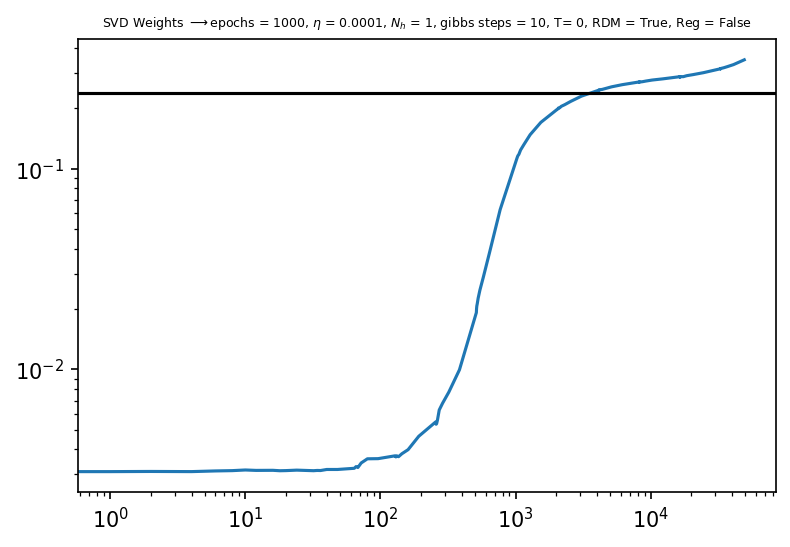

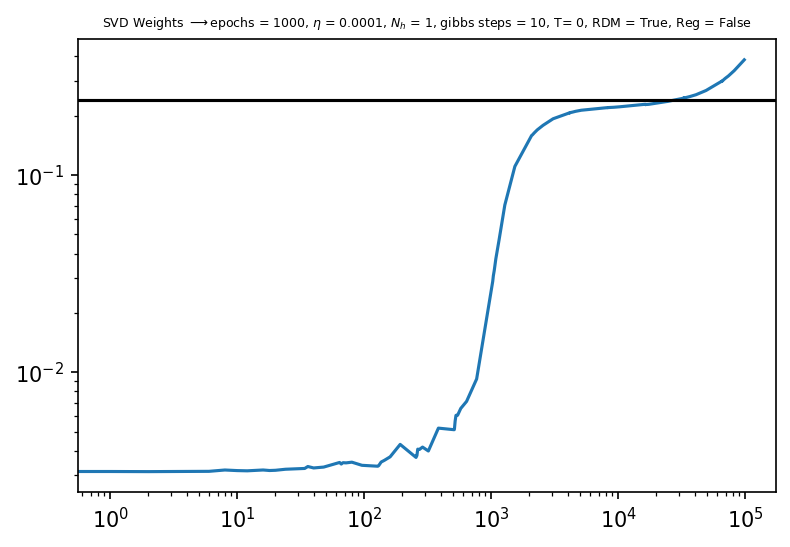

In [111]:
myRBM5.PlotW()

plt.axhline(y=0.24,color = 'k')

myRBM.PlotW()
plt.axhline(y=0.24,color = 'k')
plt.show()

### 1.5 E-4 2K regu

In [100]:
def cambio_tensor(tensor):
    mask = tensor == -1
    tensor[mask] = 0
    return tensor

filename = "beta1p5.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())
                  
D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,30):
    for m in range (1,30):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = True
lr = 1e-4
gibbs_steps = 10
epoch_max = 2000
T = 0



filename = 'files/RDMr_CWM_1.5_n1_b100_l1e4_k10_e2k.h5'
f = h5py.File(filename,'w') #w - escribir
f.create_dataset('alltime',data=time)
f.close()

myRBM6 = rbm.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_5467/3817620628.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


In [101]:
myRBM6.SetVisBias(D)
myRBM6.train(D)

It =  0 loss tensor(49.9840)
It =  1 loss tensor(24.9985)
It =  2 loss tensor(16.6602)
It =  3 loss tensor(12.4981)
It =  4 loss tensor(9.9970)
It =  5 loss tensor(8.3286)
It =  6 loss tensor(7.1429)
It =  7 loss tensor(6.2469)
It =  8 loss tensor(5.5554)
It =  9 loss tensor(5.0029)
It =  10 loss tensor(4.5464)
It =  11 loss tensor(4.1670)
It =  12 loss tensor(3.8461)
It =  13 loss tensor(3.5722)
It =  14 loss tensor(3.3317)
It =  15 loss tensor(3.1260)
It =  16 loss tensor(2.9407)
It =  17 loss tensor(2.7781)
It =  18 loss tensor(2.6293)
It =  19 loss tensor(2.5008)
It =  20 loss tensor(2.3813)
It =  21 loss tensor(2.2735)
It =  22 loss tensor(2.1728)
It =  23 loss tensor(2.0833)
It =  24 loss tensor(2.0011)
It =  25 loss tensor(1.9233)
It =  26 loss tensor(1.8512)
It =  27 loss tensor(1.7858)
It =  28 loss tensor(1.7236)
It =  29 loss tensor(1.6662)
It =  30 loss tensor(1.6120)
It =  31 loss tensor(1.5612)
It =  32 loss tensor(1.5144)
It =  33 loss tensor(1.4702)
It =  34 loss tensor

It =  277 loss tensor(0.1798)
It =  278 loss tensor(0.1792)
It =  279 loss tensor(0.1785)
It =  280 loss tensor(0.1780)
It =  281 loss tensor(0.1772)
It =  282 loss tensor(0.1766)
It =  283 loss tensor(0.1760)
It =  284 loss tensor(0.1754)
It =  285 loss tensor(0.1748)
It =  286 loss tensor(0.1743)
It =  287 loss tensor(0.1736)
It =  288 loss tensor(0.1730)
It =  289 loss tensor(0.1724)
It =  290 loss tensor(0.1718)
It =  291 loss tensor(0.1712)
It =  292 loss tensor(0.1706)
It =  293 loss tensor(0.1700)
It =  294 loss tensor(0.1695)
It =  295 loss tensor(0.1688)
It =  296 loss tensor(0.1684)
It =  297 loss tensor(0.1677)
It =  298 loss tensor(0.1672)
It =  299 loss tensor(0.1666)
It =  300 loss tensor(0.1661)
It =  301 loss tensor(0.1655)
It =  302 loss tensor(0.1650)
It =  303 loss tensor(0.1644)
It =  304 loss tensor(0.1639)
It =  305 loss tensor(0.1633)
It =  306 loss tensor(0.1629)
It =  307 loss tensor(0.1624)
It =  308 loss tensor(0.1618)
It =  309 loss tensor(0.1613)
It =  310 

It =  551 loss tensor(0.0906)
It =  552 loss tensor(0.0904)
It =  553 loss tensor(0.0902)
It =  554 loss tensor(0.0901)
It =  555 loss tensor(0.0899)
It =  556 loss tensor(0.0897)
It =  557 loss tensor(0.0896)
It =  558 loss tensor(0.0895)
It =  559 loss tensor(0.0892)
It =  560 loss tensor(0.0891)
It =  561 loss tensor(0.0890)
It =  562 loss tensor(0.0889)
It =  563 loss tensor(0.0887)
It =  564 loss tensor(0.0885)
It =  565 loss tensor(0.0883)
It =  566 loss tensor(0.0882)
It =  567 loss tensor(0.0880)
It =  568 loss tensor(0.0878)
It =  569 loss tensor(0.0877)
It =  570 loss tensor(0.0876)
It =  571 loss tensor(0.0874)
It =  572 loss tensor(0.0872)
It =  573 loss tensor(0.0871)
It =  574 loss tensor(0.0870)
It =  575 loss tensor(0.0868)
It =  576 loss tensor(0.0866)
It =  577 loss tensor(0.0865)
It =  578 loss tensor(0.0863)
It =  579 loss tensor(0.0862)
It =  580 loss tensor(0.0861)
It =  581 loss tensor(0.0859)
It =  582 loss tensor(0.0858)
It =  583 loss tensor(0.0857)
It =  584 

It =  825 loss tensor(0.0605)
It =  826 loss tensor(0.0605)
It =  827 loss tensor(0.0604)
It =  828 loss tensor(0.0603)
It =  829 loss tensor(0.0602)
It =  830 loss tensor(0.0601)
It =  831 loss tensor(0.0601)
It =  832 loss tensor(0.0600)
It =  833 loss tensor(0.0600)
It =  834 loss tensor(0.0599)
It =  835 loss tensor(0.0598)
It =  836 loss tensor(0.0598)
It =  837 loss tensor(0.0597)
It =  838 loss tensor(0.0596)
It =  839 loss tensor(0.0595)
It =  840 loss tensor(0.0594)
It =  841 loss tensor(0.0594)
It =  842 loss tensor(0.0593)
It =  843 loss tensor(0.0592)
It =  844 loss tensor(0.0591)
It =  845 loss tensor(0.0591)
It =  846 loss tensor(0.0590)
It =  847 loss tensor(0.0590)
It =  848 loss tensor(0.0589)
It =  849 loss tensor(0.0588)
It =  850 loss tensor(0.0588)
It =  851 loss tensor(0.0587)
It =  852 loss tensor(0.0586)
It =  853 loss tensor(0.0585)
It =  854 loss tensor(0.0584)
It =  855 loss tensor(0.0584)
It =  856 loss tensor(0.0583)
It =  857 loss tensor(0.0583)
It =  858 

It =  1095 loss tensor(0.0456)
It =  1096 loss tensor(0.0456)
It =  1097 loss tensor(0.0455)
It =  1098 loss tensor(0.0455)
It =  1099 loss tensor(0.0454)
It =  1100 loss tensor(0.0454)
It =  1101 loss tensor(0.0454)
It =  1102 loss tensor(0.0453)
It =  1103 loss tensor(0.0453)
It =  1104 loss tensor(0.0452)
It =  1105 loss tensor(0.0452)
It =  1106 loss tensor(0.0451)
It =  1107 loss tensor(0.0451)
It =  1108 loss tensor(0.0451)
It =  1109 loss tensor(0.0450)
It =  1110 loss tensor(0.0450)
It =  1111 loss tensor(0.0450)
It =  1112 loss tensor(0.0449)
It =  1113 loss tensor(0.0448)
It =  1114 loss tensor(0.0449)
It =  1115 loss tensor(0.0448)
It =  1116 loss tensor(0.0448)
It =  1117 loss tensor(0.0447)
It =  1118 loss tensor(0.0447)
It =  1119 loss tensor(0.0447)
It =  1120 loss tensor(0.0446)
It =  1121 loss tensor(0.0445)
It =  1122 loss tensor(0.0445)
It =  1123 loss tensor(0.0445)
It =  1124 loss tensor(0.0444)
It =  1125 loss tensor(0.0444)
It =  1126 loss tensor(0.0444)
It =  11

It =  1360 loss tensor(0.0367)
It =  1361 loss tensor(0.0367)
It =  1362 loss tensor(0.0367)
It =  1363 loss tensor(0.0367)
It =  1364 loss tensor(0.0366)
It =  1365 loss tensor(0.0366)
It =  1366 loss tensor(0.0366)
It =  1367 loss tensor(0.0366)
It =  1368 loss tensor(0.0365)
It =  1369 loss tensor(0.0365)
It =  1370 loss tensor(0.0365)
It =  1371 loss tensor(0.0364)
It =  1372 loss tensor(0.0364)
It =  1373 loss tensor(0.0364)
It =  1374 loss tensor(0.0364)
It =  1375 loss tensor(0.0363)
It =  1376 loss tensor(0.0363)
It =  1377 loss tensor(0.0363)
It =  1378 loss tensor(0.0363)
It =  1379 loss tensor(0.0362)
It =  1380 loss tensor(0.0362)
It =  1381 loss tensor(0.0362)
It =  1382 loss tensor(0.0362)
It =  1383 loss tensor(0.0361)
It =  1384 loss tensor(0.0361)
It =  1385 loss tensor(0.0361)
It =  1386 loss tensor(0.0360)
It =  1387 loss tensor(0.0360)
It =  1388 loss tensor(0.0360)
It =  1389 loss tensor(0.0360)
It =  1390 loss tensor(0.0359)
It =  1391 loss tensor(0.0359)
It =  13

It =  1625 loss tensor(0.0308)
It =  1626 loss tensor(0.0307)
It =  1627 loss tensor(0.0307)
It =  1628 loss tensor(0.0307)
It =  1629 loss tensor(0.0307)
It =  1630 loss tensor(0.0306)
It =  1631 loss tensor(0.0306)
It =  1632 loss tensor(0.0306)
It =  1633 loss tensor(0.0306)
It =  1634 loss tensor(0.0306)
It =  1635 loss tensor(0.0306)
It =  1636 loss tensor(0.0305)
It =  1637 loss tensor(0.0305)
It =  1638 loss tensor(0.0305)
It =  1639 loss tensor(0.0305)
It =  1640 loss tensor(0.0305)
It =  1641 loss tensor(0.0305)
It =  1642 loss tensor(0.0304)
It =  1643 loss tensor(0.0304)
It =  1644 loss tensor(0.0304)
It =  1645 loss tensor(0.0304)
It =  1646 loss tensor(0.0304)
It =  1647 loss tensor(0.0304)
It =  1648 loss tensor(0.0303)
It =  1649 loss tensor(0.0303)
It =  1650 loss tensor(0.0303)
It =  1651 loss tensor(0.0303)
It =  1652 loss tensor(0.0303)
It =  1653 loss tensor(0.0302)
It =  1654 loss tensor(0.0302)
It =  1655 loss tensor(0.0302)
It =  1656 loss tensor(0.0302)
It =  16

It =  1890 loss tensor(0.0264)
It =  1891 loss tensor(0.0264)
It =  1892 loss tensor(0.0264)
It =  1893 loss tensor(0.0264)
It =  1894 loss tensor(0.0264)
It =  1895 loss tensor(0.0264)
It =  1896 loss tensor(0.0264)
It =  1897 loss tensor(0.0263)
It =  1898 loss tensor(0.0263)
It =  1899 loss tensor(0.0263)
It =  1900 loss tensor(0.0263)
It =  1901 loss tensor(0.0263)
It =  1902 loss tensor(0.0263)
It =  1903 loss tensor(0.0263)
It =  1904 loss tensor(0.0262)
It =  1905 loss tensor(0.0262)
It =  1906 loss tensor(0.0262)
It =  1907 loss tensor(0.0262)
It =  1908 loss tensor(0.0262)
It =  1909 loss tensor(0.0262)
It =  1910 loss tensor(0.0262)
It =  1911 loss tensor(0.0261)
It =  1912 loss tensor(0.0261)
It =  1913 loss tensor(0.0261)
It =  1914 loss tensor(0.0261)
It =  1915 loss tensor(0.0261)
It =  1916 loss tensor(0.0261)
It =  1917 loss tensor(0.0261)
It =  1918 loss tensor(0.0261)
It =  1919 loss tensor(0.0260)
It =  1920 loss tensor(0.0260)
It =  1921 loss tensor(0.0260)
It =  19

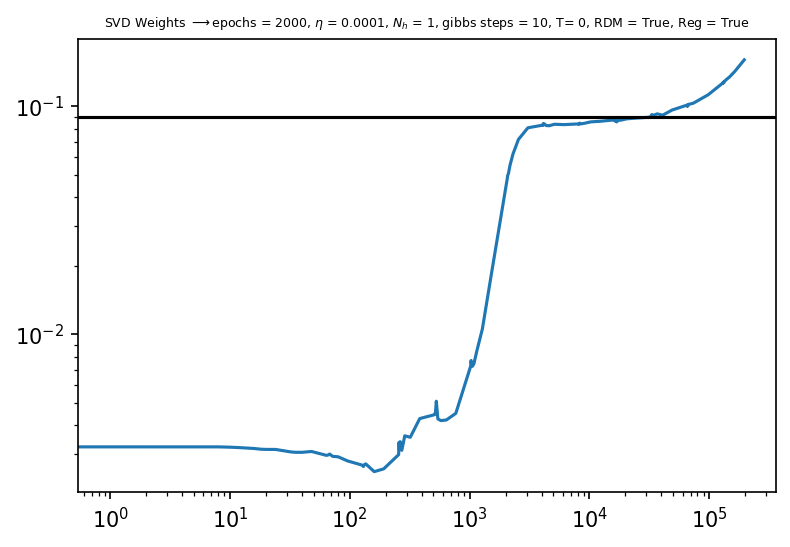

In [121]:
myRBM6.PlotW()

plt.axhline(y=0.09,color = 'k')

In [16]:
filename = 'files/RDMr_CWM_1.5_n1_b100_l1e4_k10_e2k.h5'

tlist =  [10,160,258,384,516,1056,1280,2064,2176,4096,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152,65536,65540,65552,65664]
allt3 = []
allm3 = []
allchi3 = []
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = SamplingB(X,W,b_h,b_v,it)
    
    allt3.append(t)
    allm3.append(m)
    allchi3.append(chi)

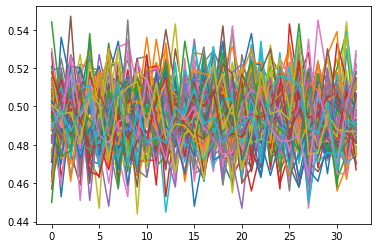

In [17]:
plt.plot(allm3);

### 1.5 e-2 5k

In [29]:
def cambio_tensor(tensor):
    mask = tensor == -1
    tensor[mask] = 0
    return tensor

filename = "beta1p5.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())
                  
D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,30):
    for m in range (1,30):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-2
gibbs_steps = 10
epoch_max = 5000
T = 0



filename = 'files/RDM_CWM_1.5_n1_b100_l1e2_k10_e5k.h5'
f = h5py.File(filename,'r') #w - escribir


myRBMG7 = rbm.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_3886/3411796458.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


In [104]:
myRBMG7.SetVisBias(D)
myRBMG7.train(D)

It =  0 loss tensor(49.9894)
It =  1 loss tensor(24.9910)
It =  2 loss tensor(16.6669)
It =  3 loss tensor(12.5022)
It =  4 loss tensor(9.9970)
It =  5 loss tensor(8.3359)
It =  6 loss tensor(7.1427)
It =  7 loss tensor(6.2480)
It =  8 loss tensor(5.5576)
It =  9 loss tensor(5.0000)
It =  10 loss tensor(4.5436)
It =  11 loss tensor(4.1675)
It =  12 loss tensor(3.8448)
It =  13 loss tensor(3.5712)
It =  14 loss tensor(3.3329)
It =  15 loss tensor(3.1253)
It =  16 loss tensor(2.9396)
It =  17 loss tensor(2.7760)
It =  18 loss tensor(2.6322)
It =  19 loss tensor(2.4994)
It =  20 loss tensor(2.3810)
It =  21 loss tensor(2.2721)
It =  22 loss tensor(2.1733)
It =  23 loss tensor(2.0829)
It =  24 loss tensor(2.0004)
It =  25 loss tensor(1.9218)
It =  26 loss tensor(1.8516)
It =  27 loss tensor(1.7857)
It =  28 loss tensor(1.7243)
It =  29 loss tensor(1.6656)
It =  30 loss tensor(1.6129)
It =  31 loss tensor(1.5621)
It =  32 loss tensor(1.5145)
It =  33 loss tensor(1.4698)
It =  34 loss tensor

It =  277 loss tensor(0.1799)
It =  278 loss tensor(0.1791)
It =  279 loss tensor(0.1787)
It =  280 loss tensor(0.1779)
It =  281 loss tensor(0.1773)
It =  282 loss tensor(0.1766)
It =  283 loss tensor(0.1761)
It =  284 loss tensor(0.1754)
It =  285 loss tensor(0.1748)
It =  286 loss tensor(0.1743)
It =  287 loss tensor(0.1737)
It =  288 loss tensor(0.1732)
It =  289 loss tensor(0.1723)
It =  290 loss tensor(0.1718)
It =  291 loss tensor(0.1713)
It =  292 loss tensor(0.1707)
It =  293 loss tensor(0.1701)
It =  294 loss tensor(0.1695)
It =  295 loss tensor(0.1689)
It =  296 loss tensor(0.1684)
It =  297 loss tensor(0.1676)
It =  298 loss tensor(0.1672)
It =  299 loss tensor(0.1665)
It =  300 loss tensor(0.1661)
It =  301 loss tensor(0.1655)
It =  302 loss tensor(0.1649)
It =  303 loss tensor(0.1645)
It =  304 loss tensor(0.1639)
It =  305 loss tensor(0.1634)
It =  306 loss tensor(0.1631)
It =  307 loss tensor(0.1622)
It =  308 loss tensor(0.1617)
It =  309 loss tensor(0.1613)
It =  310 

It =  551 loss tensor(0.0906)
It =  552 loss tensor(0.0904)
It =  553 loss tensor(0.0902)
It =  554 loss tensor(0.0901)
It =  555 loss tensor(0.0900)
It =  556 loss tensor(0.0897)
It =  557 loss tensor(0.0896)
It =  558 loss tensor(0.0895)
It =  559 loss tensor(0.0893)
It =  560 loss tensor(0.0890)
It =  561 loss tensor(0.0889)
It =  562 loss tensor(0.0888)
It =  563 loss tensor(0.0886)
It =  564 loss tensor(0.0885)
It =  565 loss tensor(0.0884)
It =  566 loss tensor(0.0883)
It =  567 loss tensor(0.0881)
It =  568 loss tensor(0.0878)
It =  569 loss tensor(0.0877)
It =  570 loss tensor(0.0875)
It =  571 loss tensor(0.0874)
It =  572 loss tensor(0.0873)
It =  573 loss tensor(0.0872)
It =  574 loss tensor(0.0869)
It =  575 loss tensor(0.0868)
It =  576 loss tensor(0.0866)
It =  577 loss tensor(0.0865)
It =  578 loss tensor(0.0864)
It =  579 loss tensor(0.0862)
It =  580 loss tensor(0.0860)
It =  581 loss tensor(0.0859)
It =  582 loss tensor(0.0858)
It =  583 loss tensor(0.0856)
It =  584 

It =  825 loss tensor(0.0606)
It =  826 loss tensor(0.0605)
It =  827 loss tensor(0.0603)
It =  828 loss tensor(0.0603)
It =  829 loss tensor(0.0603)
It =  830 loss tensor(0.0602)
It =  831 loss tensor(0.0601)
It =  832 loss tensor(0.0600)
It =  833 loss tensor(0.0599)
It =  834 loss tensor(0.0599)
It =  835 loss tensor(0.0598)
It =  836 loss tensor(0.0597)
It =  837 loss tensor(0.0596)
It =  838 loss tensor(0.0595)
It =  839 loss tensor(0.0594)
It =  840 loss tensor(0.0594)
It =  841 loss tensor(0.0594)
It =  842 loss tensor(0.0593)
It =  843 loss tensor(0.0592)
It =  844 loss tensor(0.0592)
It =  845 loss tensor(0.0591)
It =  846 loss tensor(0.0591)
It =  847 loss tensor(0.0589)
It =  848 loss tensor(0.0589)
It =  849 loss tensor(0.0588)
It =  850 loss tensor(0.0587)
It =  851 loss tensor(0.0586)
It =  852 loss tensor(0.0586)
It =  853 loss tensor(0.0585)
It =  854 loss tensor(0.0585)
It =  855 loss tensor(0.0584)
It =  856 loss tensor(0.0582)
It =  857 loss tensor(0.0584)
It =  858 

It =  1095 loss tensor(0.0456)
It =  1096 loss tensor(0.0456)
It =  1097 loss tensor(0.0455)
It =  1098 loss tensor(0.0455)
It =  1099 loss tensor(0.0453)
It =  1100 loss tensor(0.0454)
It =  1101 loss tensor(0.0455)
It =  1102 loss tensor(0.0452)
It =  1103 loss tensor(0.0454)
It =  1104 loss tensor(0.0452)
It =  1105 loss tensor(0.0452)
It =  1106 loss tensor(0.0452)
It =  1107 loss tensor(0.0451)
It =  1108 loss tensor(0.0450)
It =  1109 loss tensor(0.0451)
It =  1110 loss tensor(0.0451)
It =  1111 loss tensor(0.0450)
It =  1112 loss tensor(0.0448)
It =  1113 loss tensor(0.0449)
It =  1114 loss tensor(0.0449)
It =  1115 loss tensor(0.0448)
It =  1116 loss tensor(0.0447)
It =  1117 loss tensor(0.0447)
It =  1118 loss tensor(0.0448)
It =  1119 loss tensor(0.0447)
It =  1120 loss tensor(0.0446)
It =  1121 loss tensor(0.0445)
It =  1122 loss tensor(0.0445)
It =  1123 loss tensor(0.0445)
It =  1124 loss tensor(0.0444)
It =  1125 loss tensor(0.0444)
It =  1126 loss tensor(0.0444)
It =  11

It =  1360 loss tensor(0.0367)
It =  1361 loss tensor(0.0367)
It =  1362 loss tensor(0.0366)
It =  1363 loss tensor(0.0367)
It =  1364 loss tensor(0.0366)
It =  1365 loss tensor(0.0367)
It =  1366 loss tensor(0.0366)
It =  1367 loss tensor(0.0365)
It =  1368 loss tensor(0.0365)
It =  1369 loss tensor(0.0364)
It =  1370 loss tensor(0.0365)
It =  1371 loss tensor(0.0366)
It =  1372 loss tensor(0.0364)
It =  1373 loss tensor(0.0364)
It =  1374 loss tensor(0.0365)
It =  1375 loss tensor(0.0363)
It =  1376 loss tensor(0.0363)
It =  1377 loss tensor(0.0364)
It =  1378 loss tensor(0.0362)
It =  1379 loss tensor(0.0362)
It =  1380 loss tensor(0.0362)
It =  1381 loss tensor(0.0362)
It =  1382 loss tensor(0.0362)
It =  1383 loss tensor(0.0361)
It =  1384 loss tensor(0.0361)
It =  1385 loss tensor(0.0361)
It =  1386 loss tensor(0.0361)
It =  1387 loss tensor(0.0360)
It =  1388 loss tensor(0.0360)
It =  1389 loss tensor(0.0359)
It =  1390 loss tensor(0.0360)
It =  1391 loss tensor(0.0360)
It =  13

It =  1625 loss tensor(0.0308)
It =  1626 loss tensor(0.0307)
It =  1627 loss tensor(0.0306)
It =  1628 loss tensor(0.0306)
It =  1629 loss tensor(0.0308)
It =  1630 loss tensor(0.0307)
It =  1631 loss tensor(0.0305)
It =  1632 loss tensor(0.0306)
It =  1633 loss tensor(0.0306)
It =  1634 loss tensor(0.0306)
It =  1635 loss tensor(0.0306)
It =  1636 loss tensor(0.0307)
It =  1637 loss tensor(0.0305)
It =  1638 loss tensor(0.0305)
It =  1639 loss tensor(0.0305)
It =  1640 loss tensor(0.0304)
It =  1641 loss tensor(0.0304)
It =  1642 loss tensor(0.0305)
It =  1643 loss tensor(0.0304)
It =  1644 loss tensor(0.0304)
It =  1645 loss tensor(0.0303)
It =  1646 loss tensor(0.0304)
It =  1647 loss tensor(0.0303)
It =  1648 loss tensor(0.0303)
It =  1649 loss tensor(0.0303)
It =  1650 loss tensor(0.0303)
It =  1651 loss tensor(0.0303)
It =  1652 loss tensor(0.0302)
It =  1653 loss tensor(0.0302)
It =  1654 loss tensor(0.0303)
It =  1655 loss tensor(0.0301)
It =  1656 loss tensor(0.0302)
It =  16

It =  1890 loss tensor(0.0265)
It =  1891 loss tensor(0.0264)
It =  1892 loss tensor(0.0264)
It =  1893 loss tensor(0.0264)
It =  1894 loss tensor(0.0264)
It =  1895 loss tensor(0.0263)
It =  1896 loss tensor(0.0264)
It =  1897 loss tensor(0.0263)
It =  1898 loss tensor(0.0263)
It =  1899 loss tensor(0.0262)
It =  1900 loss tensor(0.0263)
It =  1901 loss tensor(0.0263)
It =  1902 loss tensor(0.0263)
It =  1903 loss tensor(0.0263)
It =  1904 loss tensor(0.0262)
It =  1905 loss tensor(0.0263)
It =  1906 loss tensor(0.0262)
It =  1907 loss tensor(0.0262)
It =  1908 loss tensor(0.0261)
It =  1909 loss tensor(0.0262)
It =  1910 loss tensor(0.0261)
It =  1911 loss tensor(0.0262)
It =  1912 loss tensor(0.0261)
It =  1913 loss tensor(0.0261)
It =  1914 loss tensor(0.0262)
It =  1915 loss tensor(0.0261)
It =  1916 loss tensor(0.0261)
It =  1917 loss tensor(0.0261)
It =  1918 loss tensor(0.0261)
It =  1919 loss tensor(0.0260)
It =  1920 loss tensor(0.0260)
It =  1921 loss tensor(0.0260)
It =  19

It =  2155 loss tensor(0.0232)
It =  2156 loss tensor(0.0231)
It =  2157 loss tensor(0.0232)
It =  2158 loss tensor(0.0231)
It =  2159 loss tensor(0.0231)
It =  2160 loss tensor(0.0232)
It =  2161 loss tensor(0.0233)
It =  2162 loss tensor(0.0231)
It =  2163 loss tensor(0.0232)
It =  2164 loss tensor(0.0231)
It =  2165 loss tensor(0.0231)
It =  2166 loss tensor(0.0230)
It =  2167 loss tensor(0.0230)
It =  2168 loss tensor(0.0230)
It =  2169 loss tensor(0.0230)
It =  2170 loss tensor(0.0229)
It =  2171 loss tensor(0.0231)
It =  2172 loss tensor(0.0230)
It =  2173 loss tensor(0.0230)
It =  2174 loss tensor(0.0230)
It =  2175 loss tensor(0.0230)
It =  2176 loss tensor(0.0229)
It =  2177 loss tensor(0.0230)
It =  2178 loss tensor(0.0229)
It =  2179 loss tensor(0.0229)
It =  2180 loss tensor(0.0229)
It =  2181 loss tensor(0.0229)
It =  2182 loss tensor(0.0228)
It =  2183 loss tensor(0.0229)
It =  2184 loss tensor(0.0229)
It =  2185 loss tensor(0.0229)
It =  2186 loss tensor(0.0228)
It =  21

It =  2420 loss tensor(0.0208)
It =  2421 loss tensor(0.0206)
It =  2422 loss tensor(0.0206)
It =  2423 loss tensor(0.0207)
It =  2424 loss tensor(0.0206)
It =  2425 loss tensor(0.0206)
It =  2426 loss tensor(0.0206)
It =  2427 loss tensor(0.0207)
It =  2428 loss tensor(0.0206)
It =  2429 loss tensor(0.0206)
It =  2430 loss tensor(0.0206)
It =  2431 loss tensor(0.0205)
It =  2432 loss tensor(0.0205)
It =  2433 loss tensor(0.0207)
It =  2434 loss tensor(0.0205)
It =  2435 loss tensor(0.0205)
It =  2436 loss tensor(0.0206)
It =  2437 loss tensor(0.0205)
It =  2438 loss tensor(0.0205)
It =  2439 loss tensor(0.0205)
It =  2440 loss tensor(0.0206)
It =  2441 loss tensor(0.0204)
It =  2442 loss tensor(0.0204)
It =  2443 loss tensor(0.0205)
It =  2444 loss tensor(0.0204)
It =  2445 loss tensor(0.0204)
It =  2446 loss tensor(0.0204)
It =  2447 loss tensor(0.0204)
It =  2448 loss tensor(0.0204)
It =  2449 loss tensor(0.0204)
It =  2450 loss tensor(0.0205)
It =  2451 loss tensor(0.0204)
It =  24

It =  2685 loss tensor(0.0186)
It =  2686 loss tensor(0.0187)
It =  2687 loss tensor(0.0186)
It =  2688 loss tensor(0.0187)
It =  2689 loss tensor(0.0186)
It =  2690 loss tensor(0.0185)
It =  2691 loss tensor(0.0186)
It =  2692 loss tensor(0.0185)
It =  2693 loss tensor(0.0186)
It =  2694 loss tensor(0.0186)
It =  2695 loss tensor(0.0186)
It =  2696 loss tensor(0.0184)
It =  2697 loss tensor(0.0186)
It =  2698 loss tensor(0.0186)
It =  2699 loss tensor(0.0185)
It =  2700 loss tensor(0.0185)
It =  2701 loss tensor(0.0185)
It =  2702 loss tensor(0.0185)
It =  2703 loss tensor(0.0184)
It =  2704 loss tensor(0.0184)
It =  2705 loss tensor(0.0185)
It =  2706 loss tensor(0.0184)
It =  2707 loss tensor(0.0185)
It =  2708 loss tensor(0.0184)
It =  2709 loss tensor(0.0185)
It =  2710 loss tensor(0.0184)
It =  2711 loss tensor(0.0185)
It =  2712 loss tensor(0.0184)
It =  2713 loss tensor(0.0184)
It =  2714 loss tensor(0.0185)
It =  2715 loss tensor(0.0185)
It =  2716 loss tensor(0.0184)
It =  27

It =  2950 loss tensor(0.0169)
It =  2951 loss tensor(0.0169)
It =  2952 loss tensor(0.0169)
It =  2953 loss tensor(0.0169)
It =  2954 loss tensor(0.0168)
It =  2955 loss tensor(0.0169)
It =  2956 loss tensor(0.0169)
It =  2957 loss tensor(0.0169)
It =  2958 loss tensor(0.0169)
It =  2959 loss tensor(0.0169)
It =  2960 loss tensor(0.0168)
It =  2961 loss tensor(0.0168)
It =  2962 loss tensor(0.0168)
It =  2963 loss tensor(0.0169)
It =  2964 loss tensor(0.0168)
It =  2965 loss tensor(0.0168)
It =  2966 loss tensor(0.0168)
It =  2967 loss tensor(0.0169)
It =  2968 loss tensor(0.0169)
It =  2969 loss tensor(0.0168)
It =  2970 loss tensor(0.0169)
It =  2971 loss tensor(0.0169)
It =  2972 loss tensor(0.0168)
It =  2973 loss tensor(0.0169)
It =  2974 loss tensor(0.0168)
It =  2975 loss tensor(0.0168)
It =  2976 loss tensor(0.0168)
It =  2977 loss tensor(0.0168)
It =  2978 loss tensor(0.0169)
It =  2979 loss tensor(0.0168)
It =  2980 loss tensor(0.0168)
It =  2981 loss tensor(0.0168)
It =  29

It =  3215 loss tensor(0.0155)
It =  3216 loss tensor(0.0155)
It =  3217 loss tensor(0.0155)
It =  3218 loss tensor(0.0155)
It =  3219 loss tensor(0.0156)
It =  3220 loss tensor(0.0154)
It =  3221 loss tensor(0.0155)
It =  3222 loss tensor(0.0156)
It =  3223 loss tensor(0.0155)
It =  3224 loss tensor(0.0155)
It =  3225 loss tensor(0.0156)
It =  3226 loss tensor(0.0153)
It =  3227 loss tensor(0.0156)
It =  3228 loss tensor(0.0155)
It =  3229 loss tensor(0.0155)
It =  3230 loss tensor(0.0154)
It =  3231 loss tensor(0.0156)
It =  3232 loss tensor(0.0154)
It =  3233 loss tensor(0.0154)
It =  3234 loss tensor(0.0154)
It =  3235 loss tensor(0.0154)
It =  3236 loss tensor(0.0154)
It =  3237 loss tensor(0.0154)
It =  3238 loss tensor(0.0154)
It =  3239 loss tensor(0.0155)
It =  3240 loss tensor(0.0154)
It =  3241 loss tensor(0.0155)
It =  3242 loss tensor(0.0155)
It =  3243 loss tensor(0.0154)
It =  3244 loss tensor(0.0154)
It =  3245 loss tensor(0.0155)
It =  3246 loss tensor(0.0153)
It =  32

It =  3480 loss tensor(0.0143)
It =  3481 loss tensor(0.0144)
It =  3482 loss tensor(0.0143)
It =  3483 loss tensor(0.0143)
It =  3484 loss tensor(0.0143)
It =  3485 loss tensor(0.0144)
It =  3486 loss tensor(0.0145)
It =  3487 loss tensor(0.0143)
It =  3488 loss tensor(0.0143)
It =  3489 loss tensor(0.0143)
It =  3490 loss tensor(0.0143)
It =  3491 loss tensor(0.0143)
It =  3492 loss tensor(0.0143)
It =  3493 loss tensor(0.0143)
It =  3494 loss tensor(0.0144)
It =  3495 loss tensor(0.0143)
It =  3496 loss tensor(0.0142)
It =  3497 loss tensor(0.0143)
It =  3498 loss tensor(0.0143)
It =  3499 loss tensor(0.0143)
It =  3500 loss tensor(0.0143)
It =  3501 loss tensor(0.0143)
It =  3502 loss tensor(0.0144)
It =  3503 loss tensor(0.0143)
It =  3504 loss tensor(0.0143)
It =  3505 loss tensor(0.0143)
It =  3506 loss tensor(0.0143)
It =  3507 loss tensor(0.0142)
It =  3508 loss tensor(0.0143)
It =  3509 loss tensor(0.0143)
It =  3510 loss tensor(0.0142)
It =  3511 loss tensor(0.0142)
It =  35

It =  3745 loss tensor(0.0134)
It =  3746 loss tensor(0.0133)
It =  3747 loss tensor(0.0134)
It =  3748 loss tensor(0.0133)
It =  3749 loss tensor(0.0133)
It =  3750 loss tensor(0.0133)
It =  3751 loss tensor(0.0133)
It =  3752 loss tensor(0.0134)
It =  3753 loss tensor(0.0132)
It =  3754 loss tensor(0.0132)
It =  3755 loss tensor(0.0134)
It =  3756 loss tensor(0.0132)
It =  3757 loss tensor(0.0132)
It =  3758 loss tensor(0.0133)
It =  3759 loss tensor(0.0133)
It =  3760 loss tensor(0.0133)
It =  3761 loss tensor(0.0132)
It =  3762 loss tensor(0.0132)
It =  3763 loss tensor(0.0133)
It =  3764 loss tensor(0.0133)
It =  3765 loss tensor(0.0132)
It =  3766 loss tensor(0.0133)
It =  3767 loss tensor(0.0133)
It =  3768 loss tensor(0.0133)
It =  3769 loss tensor(0.0133)
It =  3770 loss tensor(0.0132)
It =  3771 loss tensor(0.0133)
It =  3772 loss tensor(0.0133)
It =  3773 loss tensor(0.0133)
It =  3774 loss tensor(0.0132)
It =  3775 loss tensor(0.0131)
It =  3776 loss tensor(0.0133)
It =  37

It =  4010 loss tensor(0.0125)
It =  4011 loss tensor(0.0125)
It =  4012 loss tensor(0.0125)
It =  4013 loss tensor(0.0124)
It =  4014 loss tensor(0.0126)
It =  4015 loss tensor(0.0124)
It =  4016 loss tensor(0.0125)
It =  4017 loss tensor(0.0124)
It =  4018 loss tensor(0.0124)
It =  4019 loss tensor(0.0125)
It =  4020 loss tensor(0.0124)
It =  4021 loss tensor(0.0123)
It =  4022 loss tensor(0.0124)
It =  4023 loss tensor(0.0124)
It =  4024 loss tensor(0.0124)
It =  4025 loss tensor(0.0125)
It =  4026 loss tensor(0.0124)
It =  4027 loss tensor(0.0124)
It =  4028 loss tensor(0.0124)
It =  4029 loss tensor(0.0124)
It =  4030 loss tensor(0.0125)
It =  4031 loss tensor(0.0123)
It =  4032 loss tensor(0.0125)
It =  4033 loss tensor(0.0124)
It =  4034 loss tensor(0.0123)
It =  4035 loss tensor(0.0124)
It =  4036 loss tensor(0.0124)
It =  4037 loss tensor(0.0124)
It =  4038 loss tensor(0.0123)
It =  4039 loss tensor(0.0124)
It =  4040 loss tensor(0.0123)
It =  4041 loss tensor(0.0124)
It =  40

It =  4275 loss tensor(0.0116)
It =  4276 loss tensor(0.0117)
It =  4277 loss tensor(0.0117)
It =  4278 loss tensor(0.0117)
It =  4279 loss tensor(0.0118)
It =  4280 loss tensor(0.0117)
It =  4281 loss tensor(0.0117)
It =  4282 loss tensor(0.0117)
It =  4283 loss tensor(0.0116)
It =  4284 loss tensor(0.0117)
It =  4285 loss tensor(0.0116)
It =  4286 loss tensor(0.0116)
It =  4287 loss tensor(0.0117)
It =  4288 loss tensor(0.0117)
It =  4289 loss tensor(0.0117)
It =  4290 loss tensor(0.0117)
It =  4291 loss tensor(0.0117)
It =  4292 loss tensor(0.0117)
It =  4293 loss tensor(0.0117)
It =  4294 loss tensor(0.0117)
It =  4295 loss tensor(0.0116)
It =  4296 loss tensor(0.0116)
It =  4297 loss tensor(0.0117)
It =  4298 loss tensor(0.0116)
It =  4299 loss tensor(0.0116)
It =  4300 loss tensor(0.0116)
It =  4301 loss tensor(0.0117)
It =  4302 loss tensor(0.0117)
It =  4303 loss tensor(0.0116)
It =  4304 loss tensor(0.0116)
It =  4305 loss tensor(0.0117)
It =  4306 loss tensor(0.0116)
It =  43

It =  4540 loss tensor(0.0111)
It =  4541 loss tensor(0.0110)
It =  4542 loss tensor(0.0110)
It =  4543 loss tensor(0.0110)
It =  4544 loss tensor(0.0110)
It =  4545 loss tensor(0.0110)
It =  4546 loss tensor(0.0110)
It =  4547 loss tensor(0.0110)
It =  4548 loss tensor(0.0110)
It =  4549 loss tensor(0.0111)
It =  4550 loss tensor(0.0109)
It =  4551 loss tensor(0.0110)
It =  4552 loss tensor(0.0111)
It =  4553 loss tensor(0.0109)
It =  4554 loss tensor(0.0110)
It =  4555 loss tensor(0.0110)
It =  4556 loss tensor(0.0109)
It =  4557 loss tensor(0.0110)
It =  4558 loss tensor(0.0109)
It =  4559 loss tensor(0.0109)
It =  4560 loss tensor(0.0109)
It =  4561 loss tensor(0.0110)
It =  4562 loss tensor(0.0110)
It =  4563 loss tensor(0.0109)
It =  4564 loss tensor(0.0110)
It =  4565 loss tensor(0.0109)
It =  4566 loss tensor(0.0110)
It =  4567 loss tensor(0.0110)
It =  4568 loss tensor(0.0110)
It =  4569 loss tensor(0.0109)
It =  4570 loss tensor(0.0109)
It =  4571 loss tensor(0.0109)
It =  45

It =  4805 loss tensor(0.0104)
It =  4806 loss tensor(0.0105)
It =  4807 loss tensor(0.0104)
It =  4808 loss tensor(0.0104)
It =  4809 loss tensor(0.0105)
It =  4810 loss tensor(0.0104)
It =  4811 loss tensor(0.0104)
It =  4812 loss tensor(0.0104)
It =  4813 loss tensor(0.0104)
It =  4814 loss tensor(0.0103)
It =  4815 loss tensor(0.0104)
It =  4816 loss tensor(0.0104)
It =  4817 loss tensor(0.0105)
It =  4818 loss tensor(0.0104)
It =  4819 loss tensor(0.0103)
It =  4820 loss tensor(0.0104)
It =  4821 loss tensor(0.0104)
It =  4822 loss tensor(0.0103)
It =  4823 loss tensor(0.0104)
It =  4824 loss tensor(0.0104)
It =  4825 loss tensor(0.0104)
It =  4826 loss tensor(0.0102)
It =  4827 loss tensor(0.0103)
It =  4828 loss tensor(0.0104)
It =  4829 loss tensor(0.0103)
It =  4830 loss tensor(0.0103)
It =  4831 loss tensor(0.0104)
It =  4832 loss tensor(0.0104)
It =  4833 loss tensor(0.0103)
It =  4834 loss tensor(0.0104)
It =  4835 loss tensor(0.0103)
It =  4836 loss tensor(0.0103)
It =  48

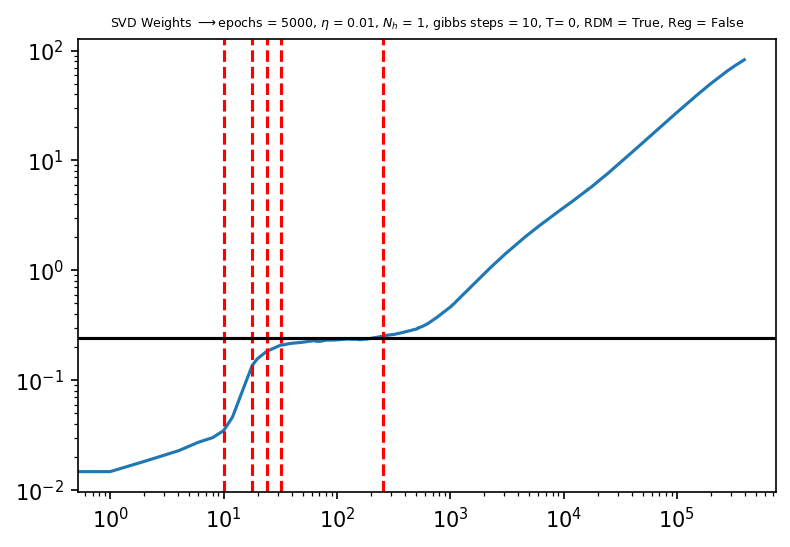

In [58]:
myRBMG7.PlotW()
xx = [10,18,24,32,256]
for i in xx:
    plt.axvline(x=i, color='r', linestyle='--', label='Línea Vertical') 
plt.axhline(y=0.24,color = 'k')

In [31]:
alltime = np.sort(f['alltime'])
alltime

array([         0,          1,          2,          4,          6,
                8,         10,         12,         16,         18,
               20,         24,         32,         34,         36,
               40,         48,         64,         66,         68,
               72,         80,         96,        128,        130,
              132,        136,        144,        160,        192,
              256,        258,        260,        264,        272,
              288,        320,        384,        512,        514,
              516,        520,        528,        544,        576,
              640,        768,       1024,       1026,       1028,
             1032,       1040,       1056,       1088,       1152,
             1280,       1536,       2048,       2050,       2052,
             2056,       2064,       2080,       2112,       2176,
             2304,       2560,       3072,       4096,       4098,
             4100,       4104,       4112,       4128,       4

In [51]:
filename = 'files/RDM_CWM_1.5_n1_b100_l1e2_k10_e5k.h5'

tlist =[10,18,24,32,40,64,80,96,130,160,256,384,512,640,768,1024,1280,1536,2050,3072,4104,5120,6144,8192,10240,16386,24576,36864,49152,65536,
65664,66048,67584,69632,73728,81920,98304,131072,139264,147456,163840,196608,262148] 

allt3 = []
allm3 = []
allchi3 = []
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = SamplingB(X,W,b_h,b_v,it)
    
    allt3.append(t)
    allm3.append(m)
    allchi3.append(chi)

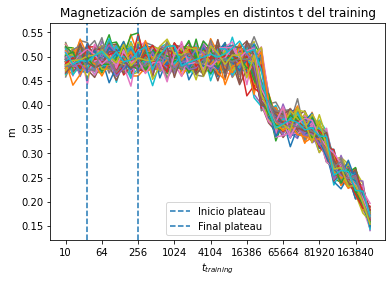

In [60]:
tiempos_uniformes = np.arange(len(allt3))

plt.plot(tiempos_uniformes, allm3);

step = len(allt3) // 10 + 1 
xticks_positions = tiempos_uniformes[::step]
xticks_labels = allt3[::step]

# Configurar las etiquetas del eje x
plt.xticks(xticks_positions, xticks_labels)

#plt.plot(allt,allm);
plt.title('Magnetización de samples en distintos t del training')
plt.xlabel('$t_{training}$')
plt.ylabel('m')
plt.axvline(x=3,  linestyle='--', label='Inicio plateau') 
plt.axvline(x=10, linestyle='--', label='Final plateau') 
plt.legend(loc='lower center')

In [43]:
allt3

[10,
 18,
 24,
 32,
 40,
 64,
 80,
 96,
 130,
 160,
 256,
 384,
 512,
 640,
 768,
 1024,
 1280,
 1536,
 2050,
 3072,
 4104,
 5120,
 6144,
 8192,
 10240,
 16386,
 24576,
 36864,
 49152]

In [2]:
def cambio_tensor(tensor):
    mask = tensor == -1
    tensor[mask] = 0
    return tensor

filename = "beta1p5.h5py"

with h5py.File(filename, "r") as f:
    data_np = f["Data"][:]

Datos = torch.tensor(data_np)
d = cambio_tensor(Datos.clone())
                  
D = torch.tensor(d,dtype = torch.float)

time = [0,1,2]
for n in range (1,30):
    for m in range (1,30):
        t = 2**n + 2**m
        time.append(t)

time = np.array(list(set(time)))
time = np.sort(time)

n_vis = D.shape[0]
n_hid = 1
dtype = torch.float
batch_size = 100
rdm = True
regu = False
lr = 1e-4
gibbs_steps = 10
epoch_max = 3000
T = 0



filename = 'files/RDM_CWM_1.5_n1_b100_l1e4_k10_e3k.h5'
f = h5py.File(filename,'w') #w - escribir
f.create_dataset('alltime',data=time)
f.close()

myRBMG8 = rbm.RBM(n_vis,n_hid,dtype,batch_size,time,rdm,regu,T,filename,lr,gibbs_steps,epoch_max)

/tmp/ipykernel_3885/2992664645.py:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  D = torch.tensor(d,dtype = torch.float)


In [3]:
myRBMG8.SetVisBias(D)
myRBMG8.train(D)

It =  0 loss tensor(49.9811)
It =  1 loss tensor(24.9877)
It =  2 loss tensor(16.6650)
It =  3 loss tensor(12.4955)
It =  4 loss tensor(9.9966)
It =  5 loss tensor(8.3331)
It =  6 loss tensor(7.1385)
It =  7 loss tensor(6.2474)
It =  8 loss tensor(5.5548)
It =  9 loss tensor(5.0009)
It =  10 loss tensor(4.5447)
It =  11 loss tensor(4.1680)
It =  12 loss tensor(3.8457)
It =  13 loss tensor(3.5727)
It =  14 loss tensor(3.3319)
It =  15 loss tensor(3.1262)
It =  16 loss tensor(2.9409)
It =  17 loss tensor(2.7781)
It =  18 loss tensor(2.6307)
It =  19 loss tensor(2.5004)
It =  20 loss tensor(2.3811)
It =  21 loss tensor(2.2735)
It =  22 loss tensor(2.1733)
It =  23 loss tensor(2.0841)
It =  24 loss tensor(2.0003)
It =  25 loss tensor(1.9237)
It =  26 loss tensor(1.8511)
It =  27 loss tensor(1.7858)
It =  28 loss tensor(1.7236)
It =  29 loss tensor(1.6659)
It =  30 loss tensor(1.6130)
It =  31 loss tensor(1.5624)
It =  32 loss tensor(1.5155)
It =  33 loss tensor(1.4707)
It =  34 loss tensor

It =  277 loss tensor(0.1799)
It =  278 loss tensor(0.1792)
It =  279 loss tensor(0.1786)
It =  280 loss tensor(0.1778)
It =  281 loss tensor(0.1773)
It =  282 loss tensor(0.1766)
It =  283 loss tensor(0.1761)
It =  284 loss tensor(0.1754)
It =  285 loss tensor(0.1748)
It =  286 loss tensor(0.1742)
It =  287 loss tensor(0.1736)
It =  288 loss tensor(0.1730)
It =  289 loss tensor(0.1726)
It =  290 loss tensor(0.1717)
It =  291 loss tensor(0.1712)
It =  292 loss tensor(0.1706)
It =  293 loss tensor(0.1700)
It =  294 loss tensor(0.1695)
It =  295 loss tensor(0.1689)
It =  296 loss tensor(0.1683)
It =  297 loss tensor(0.1678)
It =  298 loss tensor(0.1672)
It =  299 loss tensor(0.1666)
It =  300 loss tensor(0.1661)
It =  301 loss tensor(0.1655)
It =  302 loss tensor(0.1651)
It =  303 loss tensor(0.1645)
It =  304 loss tensor(0.1640)
It =  305 loss tensor(0.1634)
It =  306 loss tensor(0.1629)
It =  307 loss tensor(0.1623)
It =  308 loss tensor(0.1618)
It =  309 loss tensor(0.1612)
It =  310 

It =  551 loss tensor(0.0906)
It =  552 loss tensor(0.0903)
It =  553 loss tensor(0.0902)
It =  554 loss tensor(0.0901)
It =  555 loss tensor(0.0899)
It =  556 loss tensor(0.0898)
It =  557 loss tensor(0.0896)
It =  558 loss tensor(0.0894)
It =  559 loss tensor(0.0892)
It =  560 loss tensor(0.0891)
It =  561 loss tensor(0.0890)
It =  562 loss tensor(0.0888)
It =  563 loss tensor(0.0886)
It =  564 loss tensor(0.0885)
It =  565 loss tensor(0.0883)
It =  566 loss tensor(0.0881)
It =  567 loss tensor(0.0880)
It =  568 loss tensor(0.0878)
It =  569 loss tensor(0.0877)
It =  570 loss tensor(0.0876)
It =  571 loss tensor(0.0874)
It =  572 loss tensor(0.0872)
It =  573 loss tensor(0.0871)
It =  574 loss tensor(0.0869)
It =  575 loss tensor(0.0868)
It =  576 loss tensor(0.0866)
It =  577 loss tensor(0.0864)
It =  578 loss tensor(0.0864)
It =  579 loss tensor(0.0862)
It =  580 loss tensor(0.0861)
It =  581 loss tensor(0.0858)
It =  582 loss tensor(0.0858)
It =  583 loss tensor(0.0857)
It =  584 

It =  825 loss tensor(0.0605)
It =  826 loss tensor(0.0604)
It =  827 loss tensor(0.0604)
It =  828 loss tensor(0.0603)
It =  829 loss tensor(0.0602)
It =  830 loss tensor(0.0602)
It =  831 loss tensor(0.0601)
It =  832 loss tensor(0.0600)
It =  833 loss tensor(0.0599)
It =  834 loss tensor(0.0599)
It =  835 loss tensor(0.0598)
It =  836 loss tensor(0.0597)
It =  837 loss tensor(0.0597)
It =  838 loss tensor(0.0596)
It =  839 loss tensor(0.0595)
It =  840 loss tensor(0.0594)
It =  841 loss tensor(0.0594)
It =  842 loss tensor(0.0593)
It =  843 loss tensor(0.0592)
It =  844 loss tensor(0.0592)
It =  845 loss tensor(0.0591)
It =  846 loss tensor(0.0591)
It =  847 loss tensor(0.0590)
It =  848 loss tensor(0.0589)
It =  849 loss tensor(0.0588)
It =  850 loss tensor(0.0587)
It =  851 loss tensor(0.0587)
It =  852 loss tensor(0.0586)
It =  853 loss tensor(0.0586)
It =  854 loss tensor(0.0585)
It =  855 loss tensor(0.0584)
It =  856 loss tensor(0.0583)
It =  857 loss tensor(0.0582)
It =  858 

It =  1095 loss tensor(0.0456)
It =  1096 loss tensor(0.0456)
It =  1097 loss tensor(0.0455)
It =  1098 loss tensor(0.0455)
It =  1099 loss tensor(0.0454)
It =  1100 loss tensor(0.0454)
It =  1101 loss tensor(0.0454)
It =  1102 loss tensor(0.0453)
It =  1103 loss tensor(0.0453)
It =  1104 loss tensor(0.0452)
It =  1105 loss tensor(0.0452)
It =  1106 loss tensor(0.0452)
It =  1107 loss tensor(0.0451)
It =  1108 loss tensor(0.0451)
It =  1109 loss tensor(0.0451)
It =  1110 loss tensor(0.0450)
It =  1111 loss tensor(0.0450)
It =  1112 loss tensor(0.0449)
It =  1113 loss tensor(0.0448)
It =  1114 loss tensor(0.0448)
It =  1115 loss tensor(0.0448)
It =  1116 loss tensor(0.0448)
It =  1117 loss tensor(0.0447)
It =  1118 loss tensor(0.0447)
It =  1119 loss tensor(0.0446)
It =  1120 loss tensor(0.0446)
It =  1121 loss tensor(0.0445)
It =  1122 loss tensor(0.0445)
It =  1123 loss tensor(0.0445)
It =  1124 loss tensor(0.0444)
It =  1125 loss tensor(0.0444)
It =  1126 loss tensor(0.0444)
It =  11

It =  1360 loss tensor(0.0367)
It =  1361 loss tensor(0.0367)
It =  1362 loss tensor(0.0367)
It =  1363 loss tensor(0.0367)
It =  1364 loss tensor(0.0366)
It =  1365 loss tensor(0.0366)
It =  1366 loss tensor(0.0366)
It =  1367 loss tensor(0.0365)
It =  1368 loss tensor(0.0365)
It =  1369 loss tensor(0.0365)
It =  1370 loss tensor(0.0365)
It =  1371 loss tensor(0.0364)
It =  1372 loss tensor(0.0364)
It =  1373 loss tensor(0.0364)
It =  1374 loss tensor(0.0363)
It =  1375 loss tensor(0.0364)
It =  1376 loss tensor(0.0363)
It =  1377 loss tensor(0.0363)
It =  1378 loss tensor(0.0363)
It =  1379 loss tensor(0.0362)
It =  1380 loss tensor(0.0362)
It =  1381 loss tensor(0.0362)
It =  1382 loss tensor(0.0362)
It =  1383 loss tensor(0.0361)
It =  1384 loss tensor(0.0361)
It =  1385 loss tensor(0.0361)
It =  1386 loss tensor(0.0360)
It =  1387 loss tensor(0.0360)
It =  1388 loss tensor(0.0360)
It =  1389 loss tensor(0.0360)
It =  1390 loss tensor(0.0360)
It =  1391 loss tensor(0.0359)
It =  13

It =  1625 loss tensor(0.0307)
It =  1626 loss tensor(0.0307)
It =  1627 loss tensor(0.0307)
It =  1628 loss tensor(0.0307)
It =  1629 loss tensor(0.0307)
It =  1630 loss tensor(0.0307)
It =  1631 loss tensor(0.0306)
It =  1632 loss tensor(0.0306)
It =  1633 loss tensor(0.0306)
It =  1634 loss tensor(0.0306)
It =  1635 loss tensor(0.0306)
It =  1636 loss tensor(0.0305)
It =  1637 loss tensor(0.0305)
It =  1638 loss tensor(0.0305)
It =  1639 loss tensor(0.0305)
It =  1640 loss tensor(0.0305)
It =  1641 loss tensor(0.0304)
It =  1642 loss tensor(0.0304)
It =  1643 loss tensor(0.0304)
It =  1644 loss tensor(0.0304)
It =  1645 loss tensor(0.0304)
It =  1646 loss tensor(0.0304)
It =  1647 loss tensor(0.0303)
It =  1648 loss tensor(0.0303)
It =  1649 loss tensor(0.0303)
It =  1650 loss tensor(0.0303)
It =  1651 loss tensor(0.0303)
It =  1652 loss tensor(0.0302)
It =  1653 loss tensor(0.0302)
It =  1654 loss tensor(0.0302)
It =  1655 loss tensor(0.0302)
It =  1656 loss tensor(0.0302)
It =  16

It =  1890 loss tensor(0.0264)
It =  1891 loss tensor(0.0264)
It =  1892 loss tensor(0.0264)
It =  1893 loss tensor(0.0264)
It =  1894 loss tensor(0.0264)
It =  1895 loss tensor(0.0264)
It =  1896 loss tensor(0.0264)
It =  1897 loss tensor(0.0264)
It =  1898 loss tensor(0.0263)
It =  1899 loss tensor(0.0263)
It =  1900 loss tensor(0.0263)
It =  1901 loss tensor(0.0263)
It =  1902 loss tensor(0.0263)
It =  1903 loss tensor(0.0263)
It =  1904 loss tensor(0.0262)
It =  1905 loss tensor(0.0262)
It =  1906 loss tensor(0.0262)
It =  1907 loss tensor(0.0262)
It =  1908 loss tensor(0.0262)
It =  1909 loss tensor(0.0262)
It =  1910 loss tensor(0.0262)
It =  1911 loss tensor(0.0262)
It =  1912 loss tensor(0.0261)
It =  1913 loss tensor(0.0261)
It =  1914 loss tensor(0.0261)
It =  1915 loss tensor(0.0261)
It =  1916 loss tensor(0.0261)
It =  1917 loss tensor(0.0261)
It =  1918 loss tensor(0.0260)
It =  1919 loss tensor(0.0260)
It =  1920 loss tensor(0.0260)
It =  1921 loss tensor(0.0260)
It =  19

It =  2155 loss tensor(0.0232)
It =  2156 loss tensor(0.0232)
It =  2157 loss tensor(0.0232)
It =  2158 loss tensor(0.0231)
It =  2159 loss tensor(0.0232)
It =  2160 loss tensor(0.0231)
It =  2161 loss tensor(0.0231)
It =  2162 loss tensor(0.0231)
It =  2163 loss tensor(0.0231)
It =  2164 loss tensor(0.0231)
It =  2165 loss tensor(0.0231)
It =  2166 loss tensor(0.0231)
It =  2167 loss tensor(0.0231)
It =  2168 loss tensor(0.0230)
It =  2169 loss tensor(0.0230)
It =  2170 loss tensor(0.0230)
It =  2171 loss tensor(0.0230)
It =  2172 loss tensor(0.0230)
It =  2173 loss tensor(0.0230)
It =  2174 loss tensor(0.0230)
It =  2175 loss tensor(0.0230)
It =  2176 loss tensor(0.0230)
It =  2177 loss tensor(0.0230)
It =  2178 loss tensor(0.0229)
It =  2179 loss tensor(0.0229)
It =  2180 loss tensor(0.0229)
It =  2181 loss tensor(0.0229)
It =  2182 loss tensor(0.0229)
It =  2183 loss tensor(0.0229)
It =  2184 loss tensor(0.0229)
It =  2185 loss tensor(0.0229)
It =  2186 loss tensor(0.0229)
It =  21

It =  2420 loss tensor(0.0207)
It =  2421 loss tensor(0.0206)
It =  2422 loss tensor(0.0206)
It =  2423 loss tensor(0.0206)
It =  2424 loss tensor(0.0206)
It =  2425 loss tensor(0.0206)
It =  2426 loss tensor(0.0206)
It =  2427 loss tensor(0.0206)
It =  2428 loss tensor(0.0206)
It =  2429 loss tensor(0.0206)
It =  2430 loss tensor(0.0206)
It =  2431 loss tensor(0.0206)
It =  2432 loss tensor(0.0205)
It =  2433 loss tensor(0.0205)
It =  2434 loss tensor(0.0205)
It =  2435 loss tensor(0.0205)
It =  2436 loss tensor(0.0205)
It =  2437 loss tensor(0.0205)
It =  2438 loss tensor(0.0205)
It =  2439 loss tensor(0.0205)
It =  2440 loss tensor(0.0205)
It =  2441 loss tensor(0.0205)
It =  2442 loss tensor(0.0205)
It =  2443 loss tensor(0.0205)
It =  2444 loss tensor(0.0205)
It =  2445 loss tensor(0.0204)
It =  2446 loss tensor(0.0204)
It =  2447 loss tensor(0.0204)
It =  2448 loss tensor(0.0204)
It =  2449 loss tensor(0.0204)
It =  2450 loss tensor(0.0204)
It =  2451 loss tensor(0.0204)
It =  24

It =  2685 loss tensor(0.0186)
It =  2686 loss tensor(0.0186)
It =  2687 loss tensor(0.0186)
It =  2688 loss tensor(0.0186)
It =  2689 loss tensor(0.0186)
It =  2690 loss tensor(0.0186)
It =  2691 loss tensor(0.0186)
It =  2692 loss tensor(0.0186)
It =  2693 loss tensor(0.0186)
It =  2694 loss tensor(0.0185)
It =  2695 loss tensor(0.0185)
It =  2696 loss tensor(0.0185)
It =  2697 loss tensor(0.0185)
It =  2698 loss tensor(0.0185)
It =  2699 loss tensor(0.0185)
It =  2700 loss tensor(0.0185)
It =  2701 loss tensor(0.0185)
It =  2702 loss tensor(0.0185)
It =  2703 loss tensor(0.0185)
It =  2704 loss tensor(0.0185)
It =  2705 loss tensor(0.0185)
It =  2706 loss tensor(0.0185)
It =  2707 loss tensor(0.0185)
It =  2708 loss tensor(0.0185)
It =  2709 loss tensor(0.0184)
It =  2710 loss tensor(0.0184)
It =  2711 loss tensor(0.0184)
It =  2712 loss tensor(0.0184)
It =  2713 loss tensor(0.0184)
It =  2714 loss tensor(0.0184)
It =  2715 loss tensor(0.0184)
It =  2716 loss tensor(0.0184)
It =  27

It =  2950 loss tensor(0.0169)
It =  2951 loss tensor(0.0169)
It =  2952 loss tensor(0.0169)
It =  2953 loss tensor(0.0169)
It =  2954 loss tensor(0.0169)
It =  2955 loss tensor(0.0169)
It =  2956 loss tensor(0.0169)
It =  2957 loss tensor(0.0169)
It =  2958 loss tensor(0.0169)
It =  2959 loss tensor(0.0169)
It =  2960 loss tensor(0.0169)
It =  2961 loss tensor(0.0169)
It =  2962 loss tensor(0.0169)
It =  2963 loss tensor(0.0169)
It =  2964 loss tensor(0.0169)
It =  2965 loss tensor(0.0169)
It =  2966 loss tensor(0.0168)
It =  2967 loss tensor(0.0168)
It =  2968 loss tensor(0.0168)
It =  2969 loss tensor(0.0168)
It =  2970 loss tensor(0.0168)
It =  2971 loss tensor(0.0168)
It =  2972 loss tensor(0.0168)
It =  2973 loss tensor(0.0168)
It =  2974 loss tensor(0.0168)
It =  2975 loss tensor(0.0168)
It =  2976 loss tensor(0.0168)
It =  2977 loss tensor(0.0168)
It =  2978 loss tensor(0.0168)
It =  2979 loss tensor(0.0168)
It =  2980 loss tensor(0.0168)
It =  2981 loss tensor(0.0168)
It =  29

/home/laura/Fisicas/TFG/Codigo/main/rbm.py:207: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  W = torch.tensor(f['W'+str(ep)])


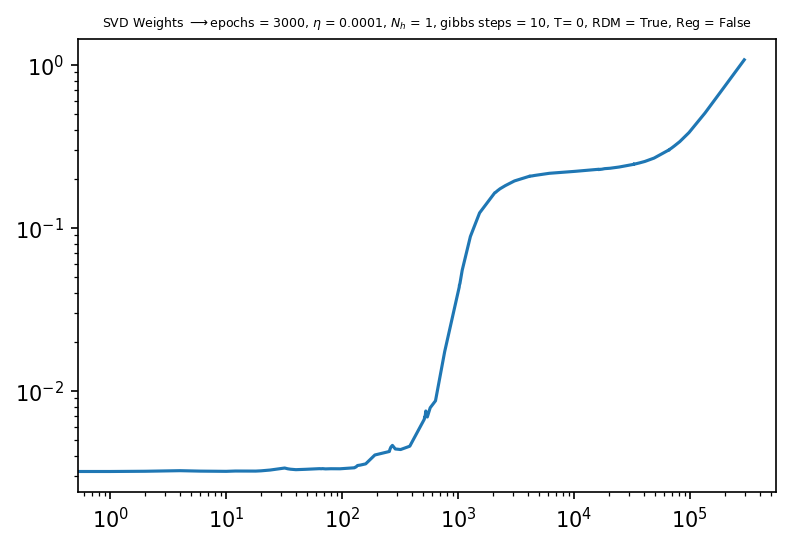

In [4]:
myRBMG8.PlotW()

In [20]:
filename = 'files/RDM_CWM_1.5_n1_b100_l1e4_k10_e3k.h5'

tlist =  [10,160,258,384,516,1056,1280,2064,2176,4096,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152,65536,65540,65552,65664]
allt3 = []
allm3 = []
allchi3 = []
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,100),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,X = SamplingB(X,W,b_h,b_v,it)
    
    allt3.append(t)
    allm3.append(m)
    allchi3.append(chi)

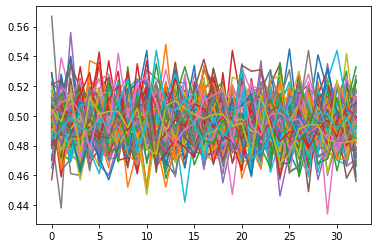

In [21]:
plt.plot(allm3);

In [1]:
def Vsampling(W,b_v,H):
        mv = torch.sigmoid((W.t().mm(H).t() + b_v).t()) #probabilidad de los nodos visibles
	
        v = torch.bernoulli(mv) #estados de los nodos visibles
        return v,mv

def Hsampling(W,b_h,V):
        
        h_mean = (W.mm(V).t() + b_h).t()
        mh = h_mean #sin sigmoide?
        h = torch.normal(mean=h_mean, std=torch.ones_like(h_mean))

        return h,mh

def Sampling(X,W,b_h,b_v,it): 
        L = X.shape[0]
        N = X.shape[1]
        
        if it==0:
            it = 10

        v = X

        h,mh = Hsampling(W,b_h,v)
        v,mv = Vsampling(W,b_v,h)

        
        for t in range(it-1):
            h,mh = Hsampling(W,b_h,v)
            v,mv = Vsampling(W,b_v,h)
            
        m = torch.mean(v, dim = 0 )
        m2 = torch.pow(m, 2)
            
        q = []
        q2 = []
        for i in range (N):
            for j in range (i+1,N):
                
                f = torch.mean((2*v[:,i]-1)*(2*v[:,j]-1))
                q.append(f) 
                q2.append(torch.pow(f, 2))
        
            
        chi = (torch.mean(m2)-torch.mean(m)**2).item()
        chi2 = ((np.mean(q2)-np.mean(q)**2)/1000).item()
            
            
        return np.array(m),np.array(chi),np.array(chi2),v #estoy guardando todas las m y la última v

In [5]:
timelist = [10,48,136,160,258,272,384,516,544,768,1028,1056,1280,2050,2064,2176,4096,4112,4352,5120,6144,8192,9216,10240,12288,16392,
          18432,20480,24576,32768,32770,33024,33280,34816,36864,40960,49152,65536,65540,65552,65664]

tlist = timelist

allt= []
allm = []
allchi = []
allchi2 = []
filename = 'files/RDMG_CWM_1p5_n1_b100_l1e4_k10_ek.h5'
f = h5py.File(filename,'r')

X = torch.bernoulli(torch.full((1000,1000),0.1))

it = 1000

for t in tlist:
    ep = int(t)
    
    if not(('W'+str(ep)) in f):
        break
        
    W = torch.tensor(f['W'+str(ep)])
    b_v = torch.tensor(f['bias_v'+str(ep)]) 
    b_h = torch.tensor(f['bias_h'+str(ep)]) 
    
    
    m,chi,chi2,X = Sampling(X,W,b_h,b_v,it)
    
    allt.append(t)
    allm.append(m)
    allchi.append(chi)
    allchi2.append(chi2)

/tmp/ipykernel_3886/1996571938.py:23: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at ../torch/csrc/utils/tensor_new.cpp:245.)
  W = torch.tensor(f['W'+str(ep)])


In [61]:
filename1 = 'files/RDM_CWM_1.5_n1_b100_l1e4_k10_ek.h5'
f1 = h5py.File(filename1,'r')
filename2 = 'files/RDM_CWM_2_n1_b100_l1e4_k10_ek.h5'
f2 = h5py.File(filename2,'r')

Text(0.5, 1.0, 'SVD Weights  $\\longrightarrow$epochs = 1000, $\\eta$ = 0.0001, $N_h$ = 1, gibbs steps = 10, T= 0, RDM = True, Reg = False ')

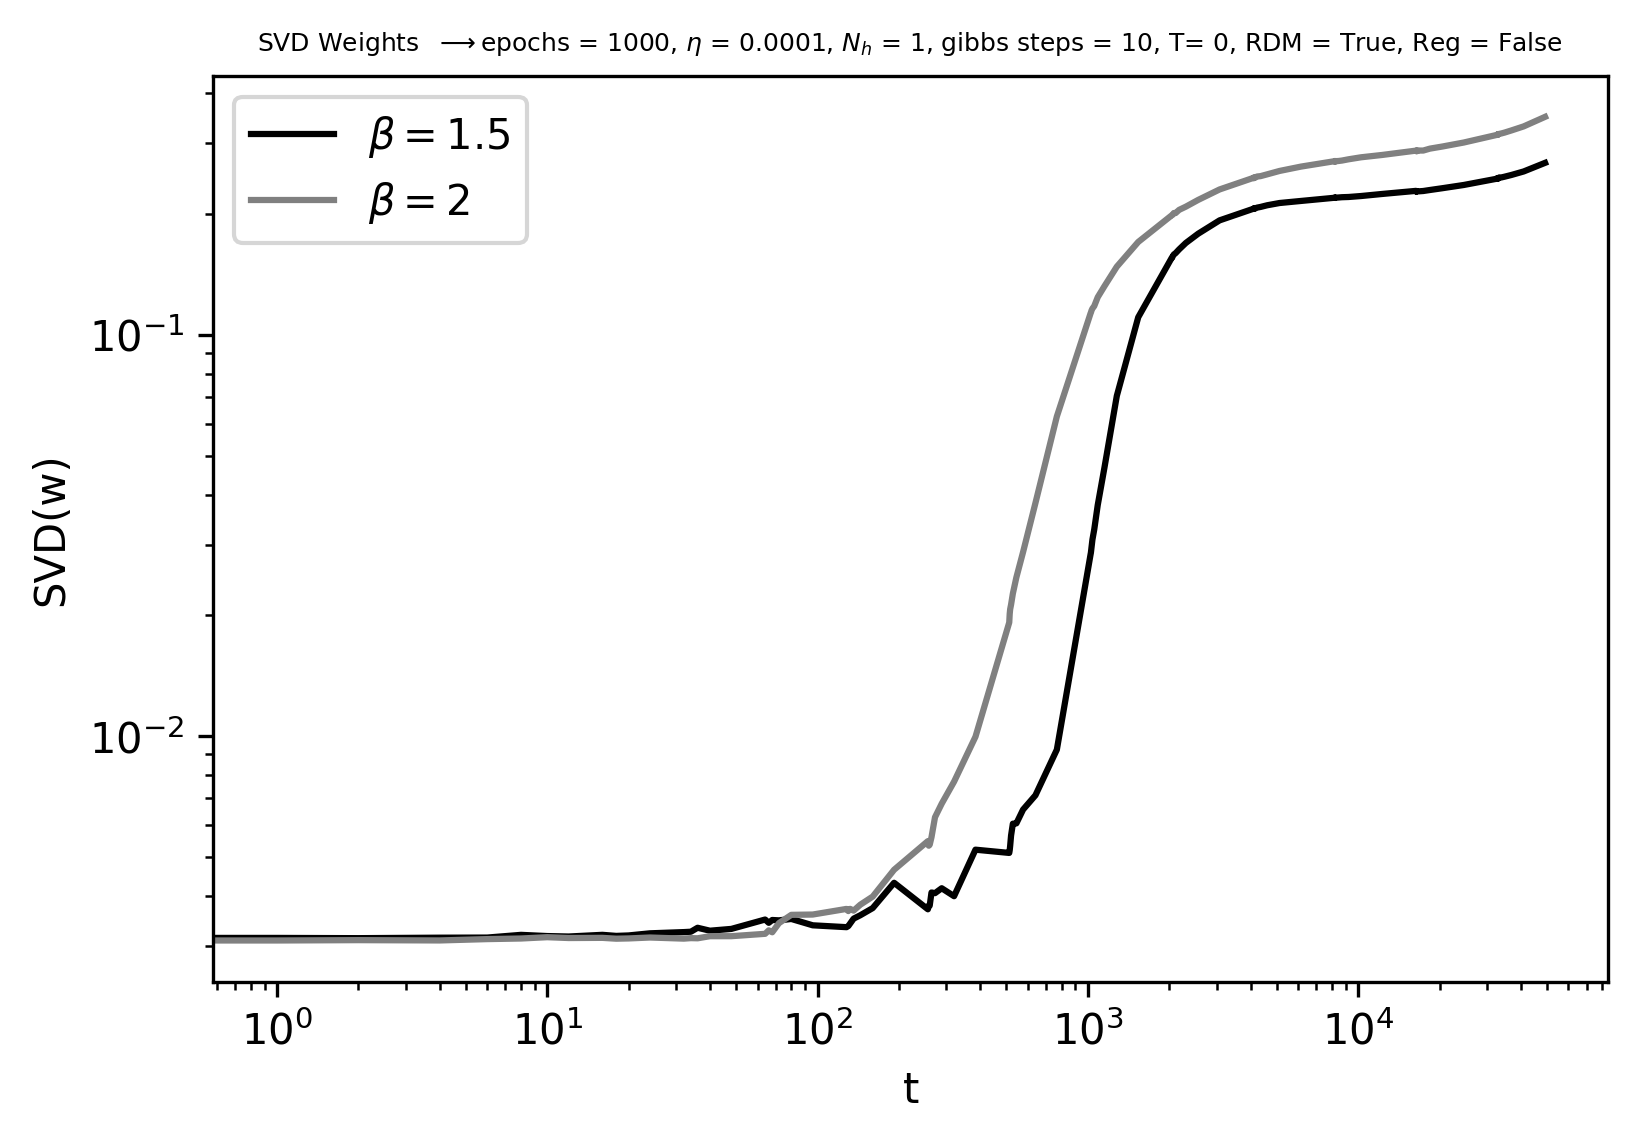

In [62]:
allw1 = []
allt1 = []
allw2 = []
alltime1 = np.sort(f1['alltime'])

for t in alltime1:
    ep = int(t) # epoch to which retrieve the RBM
            
    if not(('bias_h'+str(ep)) in f1): # check for last time
            break
    if not(('bias_h'+str(ep)) in f2): # check for last time
            break
            
    W1 = torch.tensor(f1['W'+str(ep)])  
    W2 = torch.tensor(f2['W'+str(ep)])  
    
    _,s1,_ = torch.svd(W1)
    _,s2,_ = torch.svd(W2)
    
    allw1.append(s1.reshape(s1.shape[0],1))  
    allw2.append(s2.reshape(s2.shape[0],1))  

    allt1.append(ep)
            
allt1 = np.array(allt1)

plt.figure(dpi = 300)
plt.loglog(np.array(allt1),allw1, label = r'$\beta=1.5$',color = 'k')
plt.loglog(np.array(allt1),allw2, label = r'$\beta=2$',color = 'grey')
plt.xlabel('t')
plt.ylabel('SVD(w)')
plt.legend()
plt.title('SVD Weights  $\longrightarrow$epochs = 1000, $\eta$ = 0.0001, $N_h$ = 1, gibbs steps = 10, T= 0, RDM = True, Reg = False ', fontsize = 6)